In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
%matplotlib inline 
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import normalize
import pandas as pd
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report

import os 
from keras.layers import Conv1D, MaxPooling1D, SpatialDropout1D
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from keras.utils.vis_utils import plot_model
from keras import initializers
from keras import regularizers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import Model
from tqdm import tqdm # Processing time measurement
from sklearn.model_selection import train_test_split 
from keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from keras import optimizers # Allow us to access the Adam class to modify some parameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold # Used to use Kfold to train our model
from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting

Using TensorFlow backend.
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflo

In [2]:
train = pd.read_csv("data/7C_train.csv", sep="\t")
valid = pd.read_csv("data/7C_valid.csv", sep="\t")

y_train = train["Compartment Prediction"]
y_valid = valid["Compartment Prediction"]

x_train = train["Sequence"].copy()
x_valid = valid["Sequence"].copy()

In [3]:
print(len(x_train), 'train sequences')
print(len(x_valid), 'valid sequences')

2660 train sequences
666 valid sequences


In [4]:
max_len = 1500

In [5]:
# all amino acids (in blosum order)
aa = "*ARNDCQEGHILKMFPSTWYVU"
tot_aa = len(aa)

# define a mapping of aa to integers
aa_to_int = dict((c, i) for i, c in enumerate(aa))
int_to_aa = dict((i, c) for i, c in enumerate(aa))

## One hot encoding of Labels

In [6]:
# NB: DO NOT USE SET, IT CHANGES ORDER OF CATEGORY EVERYTIME I RUN THE NOTEBOOK!!!!
#cat = list(set(y_train))
cat = ['ER',
 'Golgi',
 'Mitochondrion',
 'Endosome',
 'Large Protein Complex',
 'Plasma membrane',
 'Lysosome']

In [7]:
tot_cat = len(cat)
cat_to_int = {}
int_to_cat = {}
for i in range(tot_cat):
    cat_to_int[cat[i]] = i
    int_to_cat[i] = cat[i]   

In [8]:
def cat_to_indices(Y):
    Y_indices = np.zeros([Y.shape[0],], dtype=int)
    for i in range(len(Y)):
        Y_indices[i] = cat_to_int[Y[i]]
    return Y_indices

# one hot encode
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [9]:
y_train_indices = cat_to_indices(y_train)
y_valid_indices = cat_to_indices(y_valid)

y_train_OH = convert_to_one_hot(y_train_indices, C = tot_cat)
y_valid_OH = convert_to_one_hot(y_valid_indices, C = tot_cat)

## X_train processing: 
### From Sequences to list of indices

In [10]:
# Function to convert sequences to array of indices. I will use that one for embedding 

def seq_to_indices(X, aa_to_int, max_len):
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = []
    
    for i in range(m):                               # loop over training examples
        seq_aa = X[i]
        seq_ind = []
        
        # Loop over the words of sentence_words
        for w in range(len(seq_aa)):
            seq_ind.append(aa_to_int[seq_aa[w]])
            
        X_indices.append(seq_ind)
            
    ### END CODE HERE ###
    
    return X_indices

In [11]:
x_train_indices = seq_to_indices(x_train, aa_to_int, max_len)
x_valid_indices = seq_to_indices(x_valid, aa_to_int, max_len)

In [12]:
# Pad sequences
# By default, the padding is added before the sequence
x_train_pad = sequence.pad_sequences(x_train_indices, maxlen=max_len, value=aa_to_int["*"])
x_valid_pad = sequence.pad_sequences(x_valid_indices, maxlen=max_len, value=aa_to_int["*"])
print('x_train shape:', x_train_pad.shape)
print('x_valid shape:', x_valid_pad.shape)

x_train shape: (2660, 1500)
x_valid shape: (666, 1500)


In [13]:
# One hot to label 
#Y is list of OH vector
def OH_to_label_indices(Y):
    labels = []
    for a in Y:
        indices = np.argmax(a)
        labels.append(indices)
    return labels

In [14]:
def indices_to_cat(Y):
    Y_cat = []
    for i in range(len(Y)):
        Y_cat.append(int_to_cat[Y[i]])
    return Y_cat

## Model 1

In [18]:
max_features = tot_aa
batch_size = 32

#LSTM
units = 128
# Embedding
embedding_size = 48
# Convolution
filters = 20
pool_size = 2

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(input_dim=max_features,output_dim=embedding_size,
        input_length=max_len, name = 'embedding_layer', trainable=True, mask_zero=False)(_input)

drop = Dropout(0.2)(embedded)
# Convolution layer of different size

conv2 = Conv1D(filters, 2, padding='same', activation='relu', 
              strides=1)(drop)
drop2 = SpatialDropout1D(0.2)(conv2)
pool2 = MaxPooling1D(pool_size=pool_size)(drop2)

conv3 = Conv1D(filters, 3, padding='same', activation='relu', 
              strides=1)(drop)
drop3 = SpatialDropout1D(0.2)(conv3)
pool3 = MaxPooling1D(pool_size=pool_size)(drop3)

conv5 = Conv1D(filters, 5, padding='same', activation='relu', 
              strides=1)(drop)
drop5 = SpatialDropout1D(0.2)(conv5)
pool5 = MaxPooling1D(pool_size=pool_size)(drop5)

conv9 = Conv1D(filters, 9, padding='same', activation='relu', 
              strides=1)(drop)
drop9 = SpatialDropout1D(0.2)(conv9)
pool9 = MaxPooling1D(pool_size=pool_size)(drop9)

conv12 = Conv1D(filters, 12, padding='same', activation='relu', 
              strides=1)(drop)
drop12 = SpatialDropout1D(0.2)(conv12)
pool12 = MaxPooling1D(pool_size=pool_size)(drop12)

conv16 = Conv1D(filters, 16, padding='same', activation='relu', 
              strides=1)(drop)
drop16 = SpatialDropout1D(0.2)(conv16)
pool16 = MaxPooling1D(pool_size=pool_size)(drop16)

# Concatenate the filters
#concat = concatenate([drop2, drop3, drop5, drop9, drop12], axis=2)
concat = concatenate([pool2, pool3, pool5, pool9, pool12, pool16], axis=2)

#pool = MaxPooling1D(pool_size=pool_size)(concat)

activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(concat)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(7, activation='softmax')(sent_representation)

model = Model(inputs=_input, outputs=probabilities)

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models/model1_weights.hdf5', 
                           verbose=1, save_best_only=True)
# Train, train, train
history = model.fit(x_train_pad, y_train_OH, 
                    batch_size=32, epochs=60,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Instructions for updating:
Use tf.cast instead.
Train on 2660 samples, validate on 666 samples
Epoch 1/60
2660/2660 [==============================] - 248s 93ms/step - loss: 1.4826 - accuracy: 0.5120 - val_loss: 1.4928 - val_accuracy: 0.5165

Epoch 00001: val_loss improved from inf to 1.49283, saving model to models/model1_weights.hdf5
Epoch 2/60
2660/2660 [==============================] - 209s 78ms/step - loss: 1.3886 - accuracy: 0.5222 - val_loss: 1.4908 - val_accuracy: 0.5015

Epoch 00002: val_loss improved from 1.49283 to 1.49077, saving model to models/model1_weights.hdf5
Epoch 3/60
2660/2660 [==============================] - 207s 78ms/step - loss: 1.3296 - accuracy: 0.5447 - val_loss: 1.2780 - val_accuracy: 0.5601

Epoch 00003: val_loss improved from 1.49077 to 1.27803, saving model to models/model1_weights.hdf5
Epoch 4/60
2660/2660 [==============================] - 206s 77ms/step - loss: 1.2447 - accuracy: 0.5797 - val_loss: 1.2303 - val_accuracy: 0.5856

Epoch 00004: val_los


Epoch 00036: val_loss did not improve from 0.86572
Epoch 37/60
2660/2660 [==============================] - 205s 77ms/step - loss: 0.7715 - accuracy: 0.7669 - val_loss: 0.8592 - val_accuracy: 0.7372

Epoch 00037: val_loss improved from 0.86572 to 0.85917, saving model to models/model1_weights.hdf5
Epoch 38/60
2660/2660 [==============================] - 207s 78ms/step - loss: 0.7716 - accuracy: 0.7635 - val_loss: 0.8626 - val_accuracy: 0.7342

Epoch 00038: val_loss did not improve from 0.85917
Epoch 39/60
2660/2660 [==============================] - 205s 77ms/step - loss: 0.7580 - accuracy: 0.7662 - val_loss: 0.8802 - val_accuracy: 0.7372

Epoch 00039: val_loss did not improve from 0.85917
Epoch 40/60
2660/2660 [==============================] - 205s 77ms/step - loss: 0.7523 - accuracy: 0.7673 - val_loss: 0.8614 - val_accuracy: 0.7402

Epoch 00040: val_loss did not improve from 0.85917
Epoch 41/60
2660/2660 [==============================] - 210s 79ms/step - loss: 0.7366 - accuracy: 0

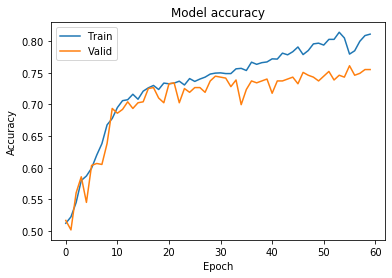

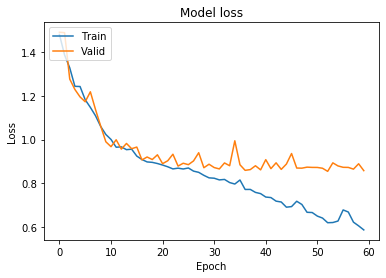

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [15]:
model = load_model('models/model1_weights.hdf5')
model.evaluate(x_valid_pad, y_valid_OH, verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


[0.8545500505435932, 0.7387387156486511]

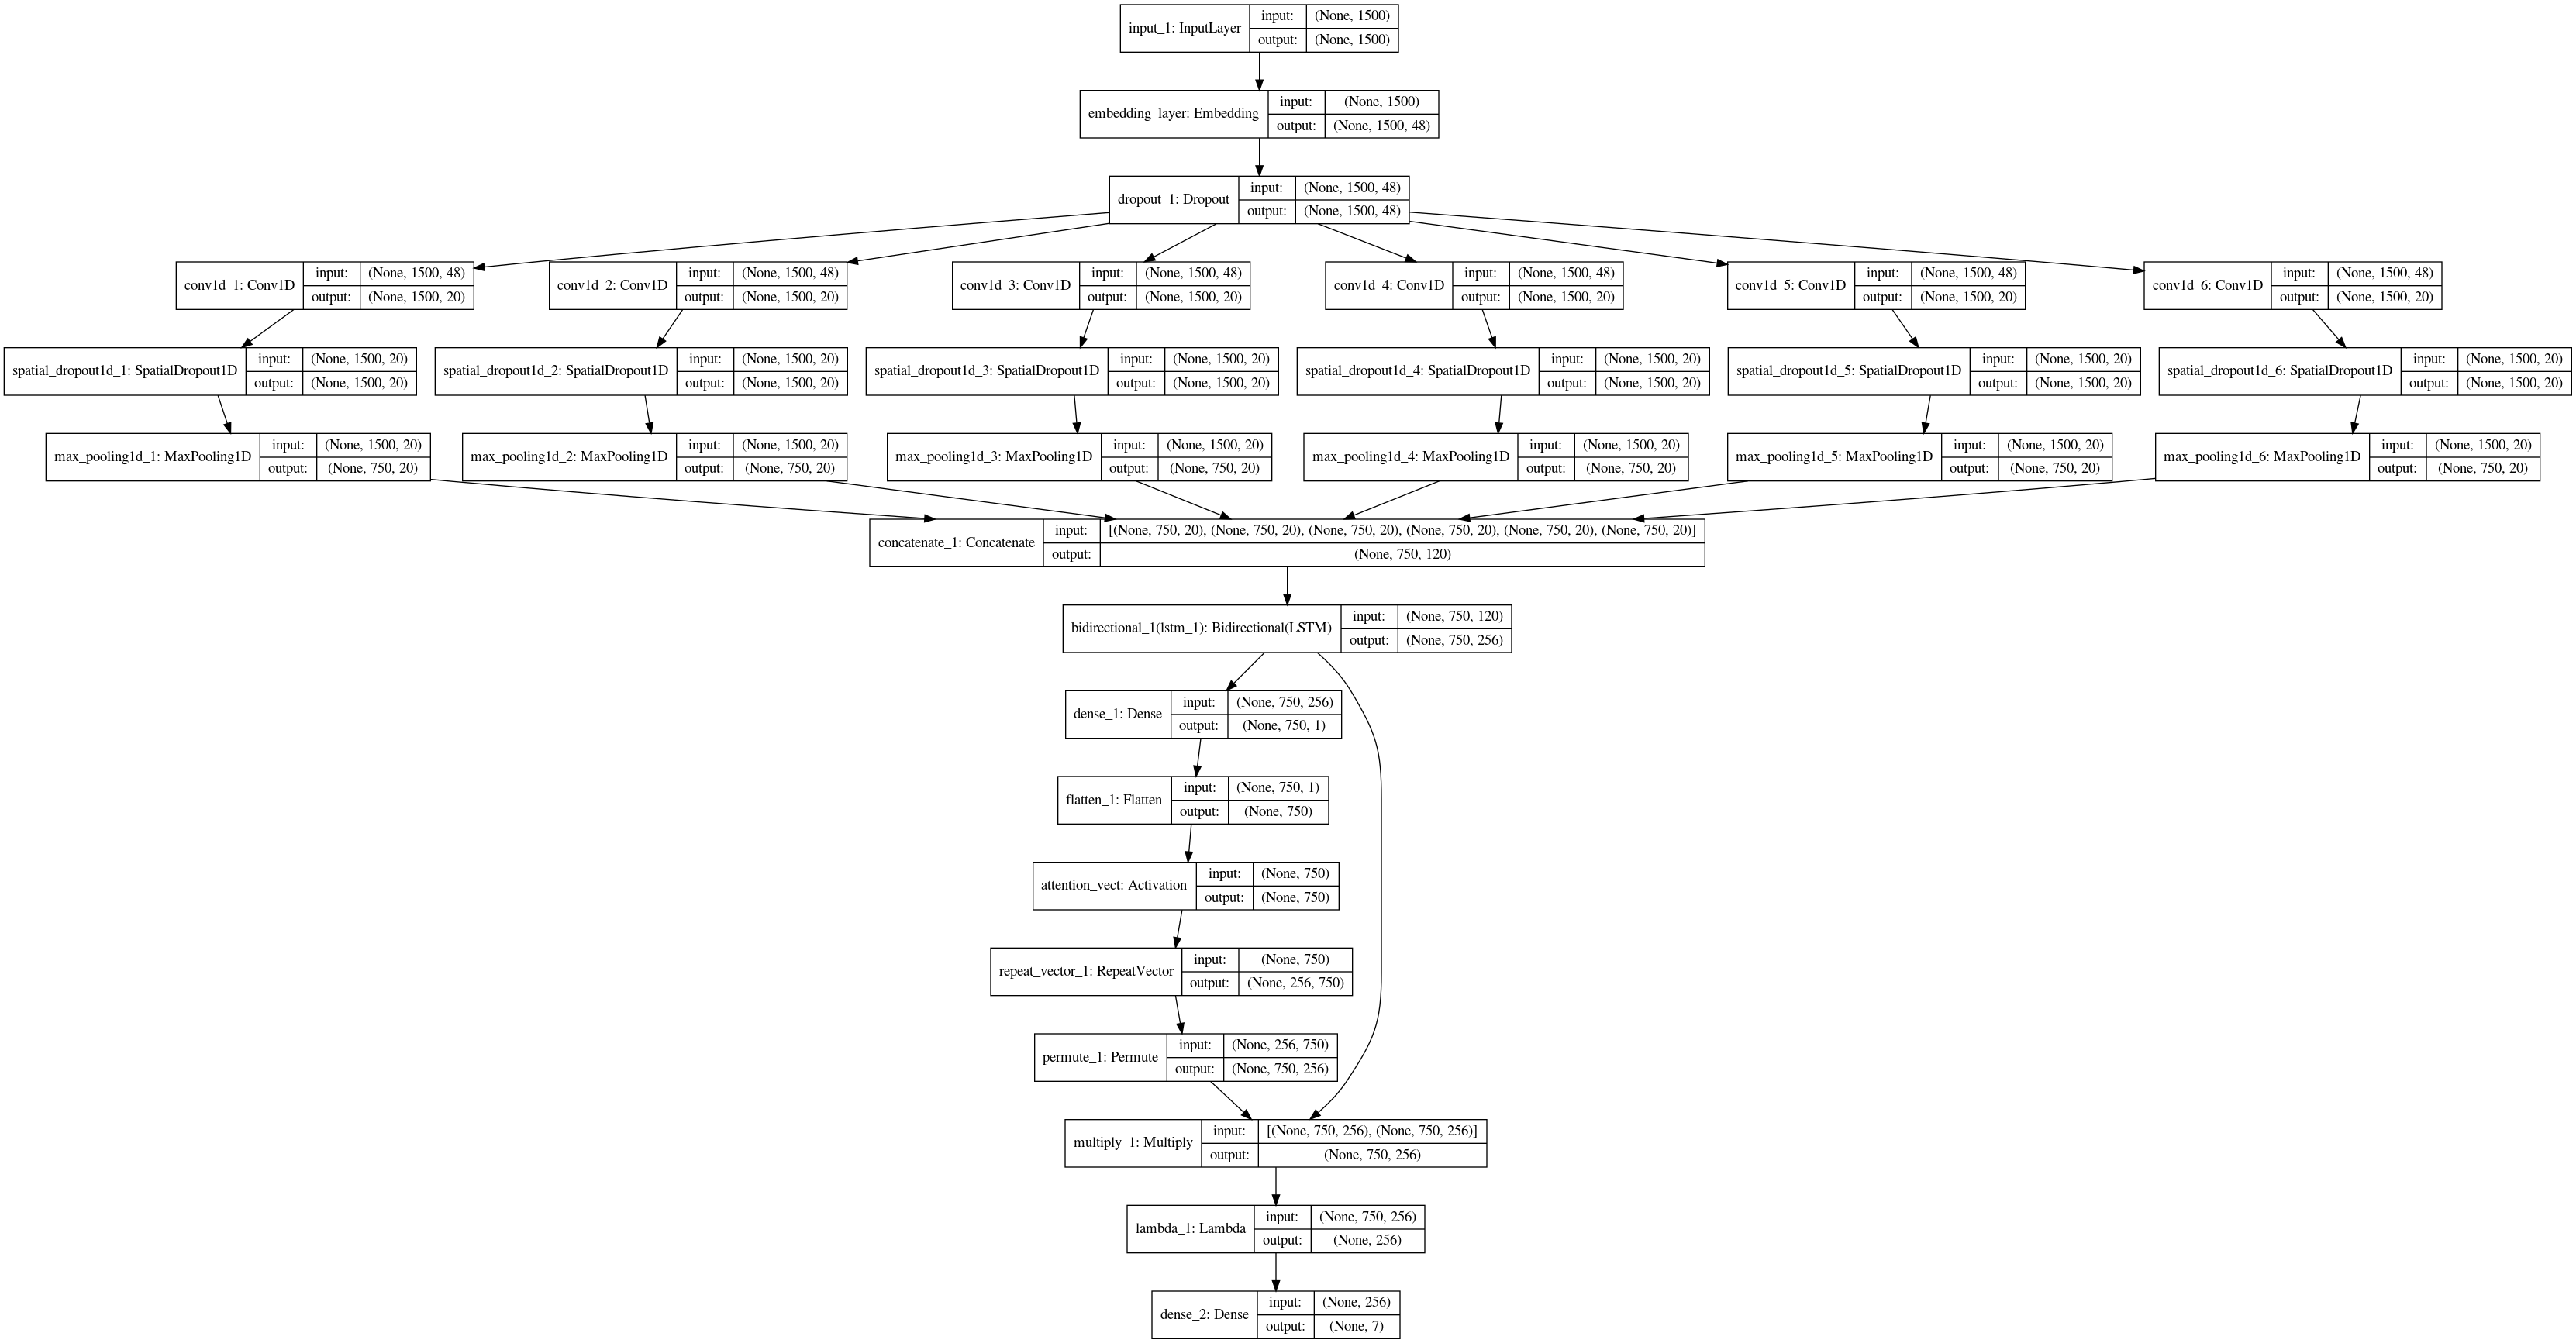

In [16]:
plot_model(model, to_file='models/model1_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
y_pred = model.predict(x_valid_pad)
y_pred_indices = OH_to_label_indices(y_pred)
y_pred_label = indices_to_cat(y_pred_indices)

In [18]:
def confusion_plot(y_valid, y_pred_label, cat):
    conf_mx = confusion_matrix(y_valid, y_pred_label, labels=cat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mx, cmap=plt.cm.gray)
    fig.colorbar(cax)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.set_xticklabels([''] + cat,  rotation='vertical')
    ax.set_yticklabels([''] + cat)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

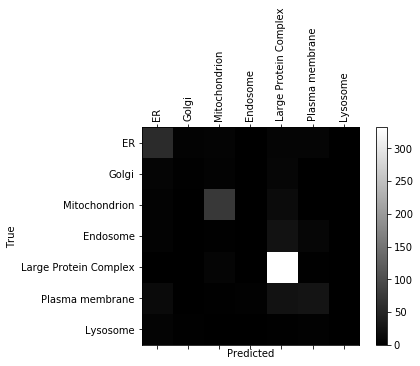

In [19]:
confusion_plot(y_valid, y_pred_label, cat)

In [20]:
def confusion_plot_norm(y_valid, y_pred_label, cat, axis=1):
    conf_mx = confusion_matrix(y_valid, y_pred_label, labels=cat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mx / (conf_mx.max(axis=axis)+1), cmap=plt.cm.gray)
    fig.colorbar(cax)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.set_xticklabels([''] + cat,  rotation='vertical')
    ax.set_yticklabels([''] + cat)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return(conf_mx)

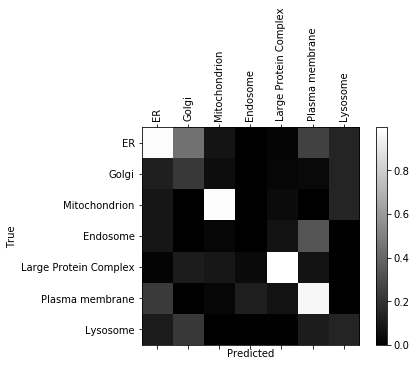

In [25]:
conf = confusion_plot_norm(y_valid, y_pred_label, cat, axis=1)

In [26]:
conf

array([[ 56,   4,   6,   0,   7,   7,   1],
       [  7,   2,   4,   0,   8,   1,   1],
       [  5,   0,  75,   0,  15,   0,   1],
       [  5,   0,   2,   0,  24,   9,   0],
       [  1,   1,   7,   1, 332,   2,   0],
       [ 13,   0,   2,   3,  24,  26,   0],
       [  6,   2,   0,   0,   2,   3,   1]])

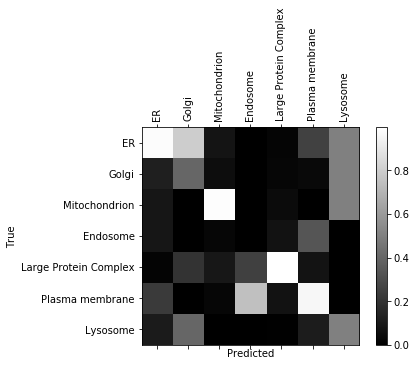

In [27]:
conf = confusion_plot_norm(y_valid, y_pred_label, cat, axis=0)

In [28]:
print(classification_report(y_valid, y_pred_label))

                       precision    recall  f1-score   support

                   ER       0.60      0.69      0.64        81
             Endosome       0.00      0.00      0.00        40
                Golgi       0.22      0.09      0.12        23
Large Protein Complex       0.81      0.97      0.88       344
             Lysosome       0.25      0.07      0.11        14
        Mitochondrion       0.78      0.78      0.78        96
      Plasma membrane       0.54      0.38      0.45        68

             accuracy                           0.74       666
            macro avg       0.46      0.43      0.43       666
         weighted avg       0.67      0.74      0.70       666



# Model 2
CNN optimization

In [15]:
max_features = tot_aa
batch_size = 32

#LSTM
units = 160
# Embedding
embedding_size = 48
# Convolution
filters = 20
pool_size = 2

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(input_dim=max_features,output_dim=embedding_size,
        input_length=max_len, name = 'embedding_layer', trainable=True, mask_zero=False)(_input)

drop = Dropout(0.2)(embedded)
# Convolution layer of different size

conv3 = Conv1D(filters, 3, padding='same', activation='relu', 
              strides=1)(drop)
drop3 = SpatialDropout1D(0.2)(conv3)
#pool3 = MaxPooling1D(pool_size=pool_size)(drop3)

conv5 = Conv1D(filters, 5, padding='same', activation='relu', 
              strides=1)(drop)
drop5 = SpatialDropout1D(0.2)(conv5)
#pool5 = MaxPooling1D(pool_size=pool_size)(drop5)

conv9 = Conv1D(filters, 9, padding='same', activation='relu', 
              strides=1)(drop)
drop9 = SpatialDropout1D(0.2)(conv9)
#pool9 = MaxPooling1D(pool_size=pool_size)(drop9)

conv15 = Conv1D(filters, 15, padding='same', activation='relu', 
              strides=1)(drop)
drop15 = SpatialDropout1D(0.2)(conv15)
#pool15 = MaxPooling1D(pool_size=pool_size)(drop15)

conv21 = Conv1D(filters, 21, padding='same', activation='relu', 
              strides=1)(drop)
drop21 = SpatialDropout1D(0.2)(conv21)
#pool21 = MaxPooling1D(pool_size=pool_size)(drop21)

# Concatenate the filters
concat = concatenate([drop, drop3, drop5, drop9, drop15, drop21], axis=2)
#concat = concatenate([pool2, pool3, pool5, pool9, pool12, pool16], axis=2)

#pool = MaxPooling1D(pool_size=pool_size)(concat)

activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(concat)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(7, activation='softmax')(sent_representation)

model = Model(inputs=_input, outputs=probabilities)

Instructions for updating:
Colocations handled automatically by placer.


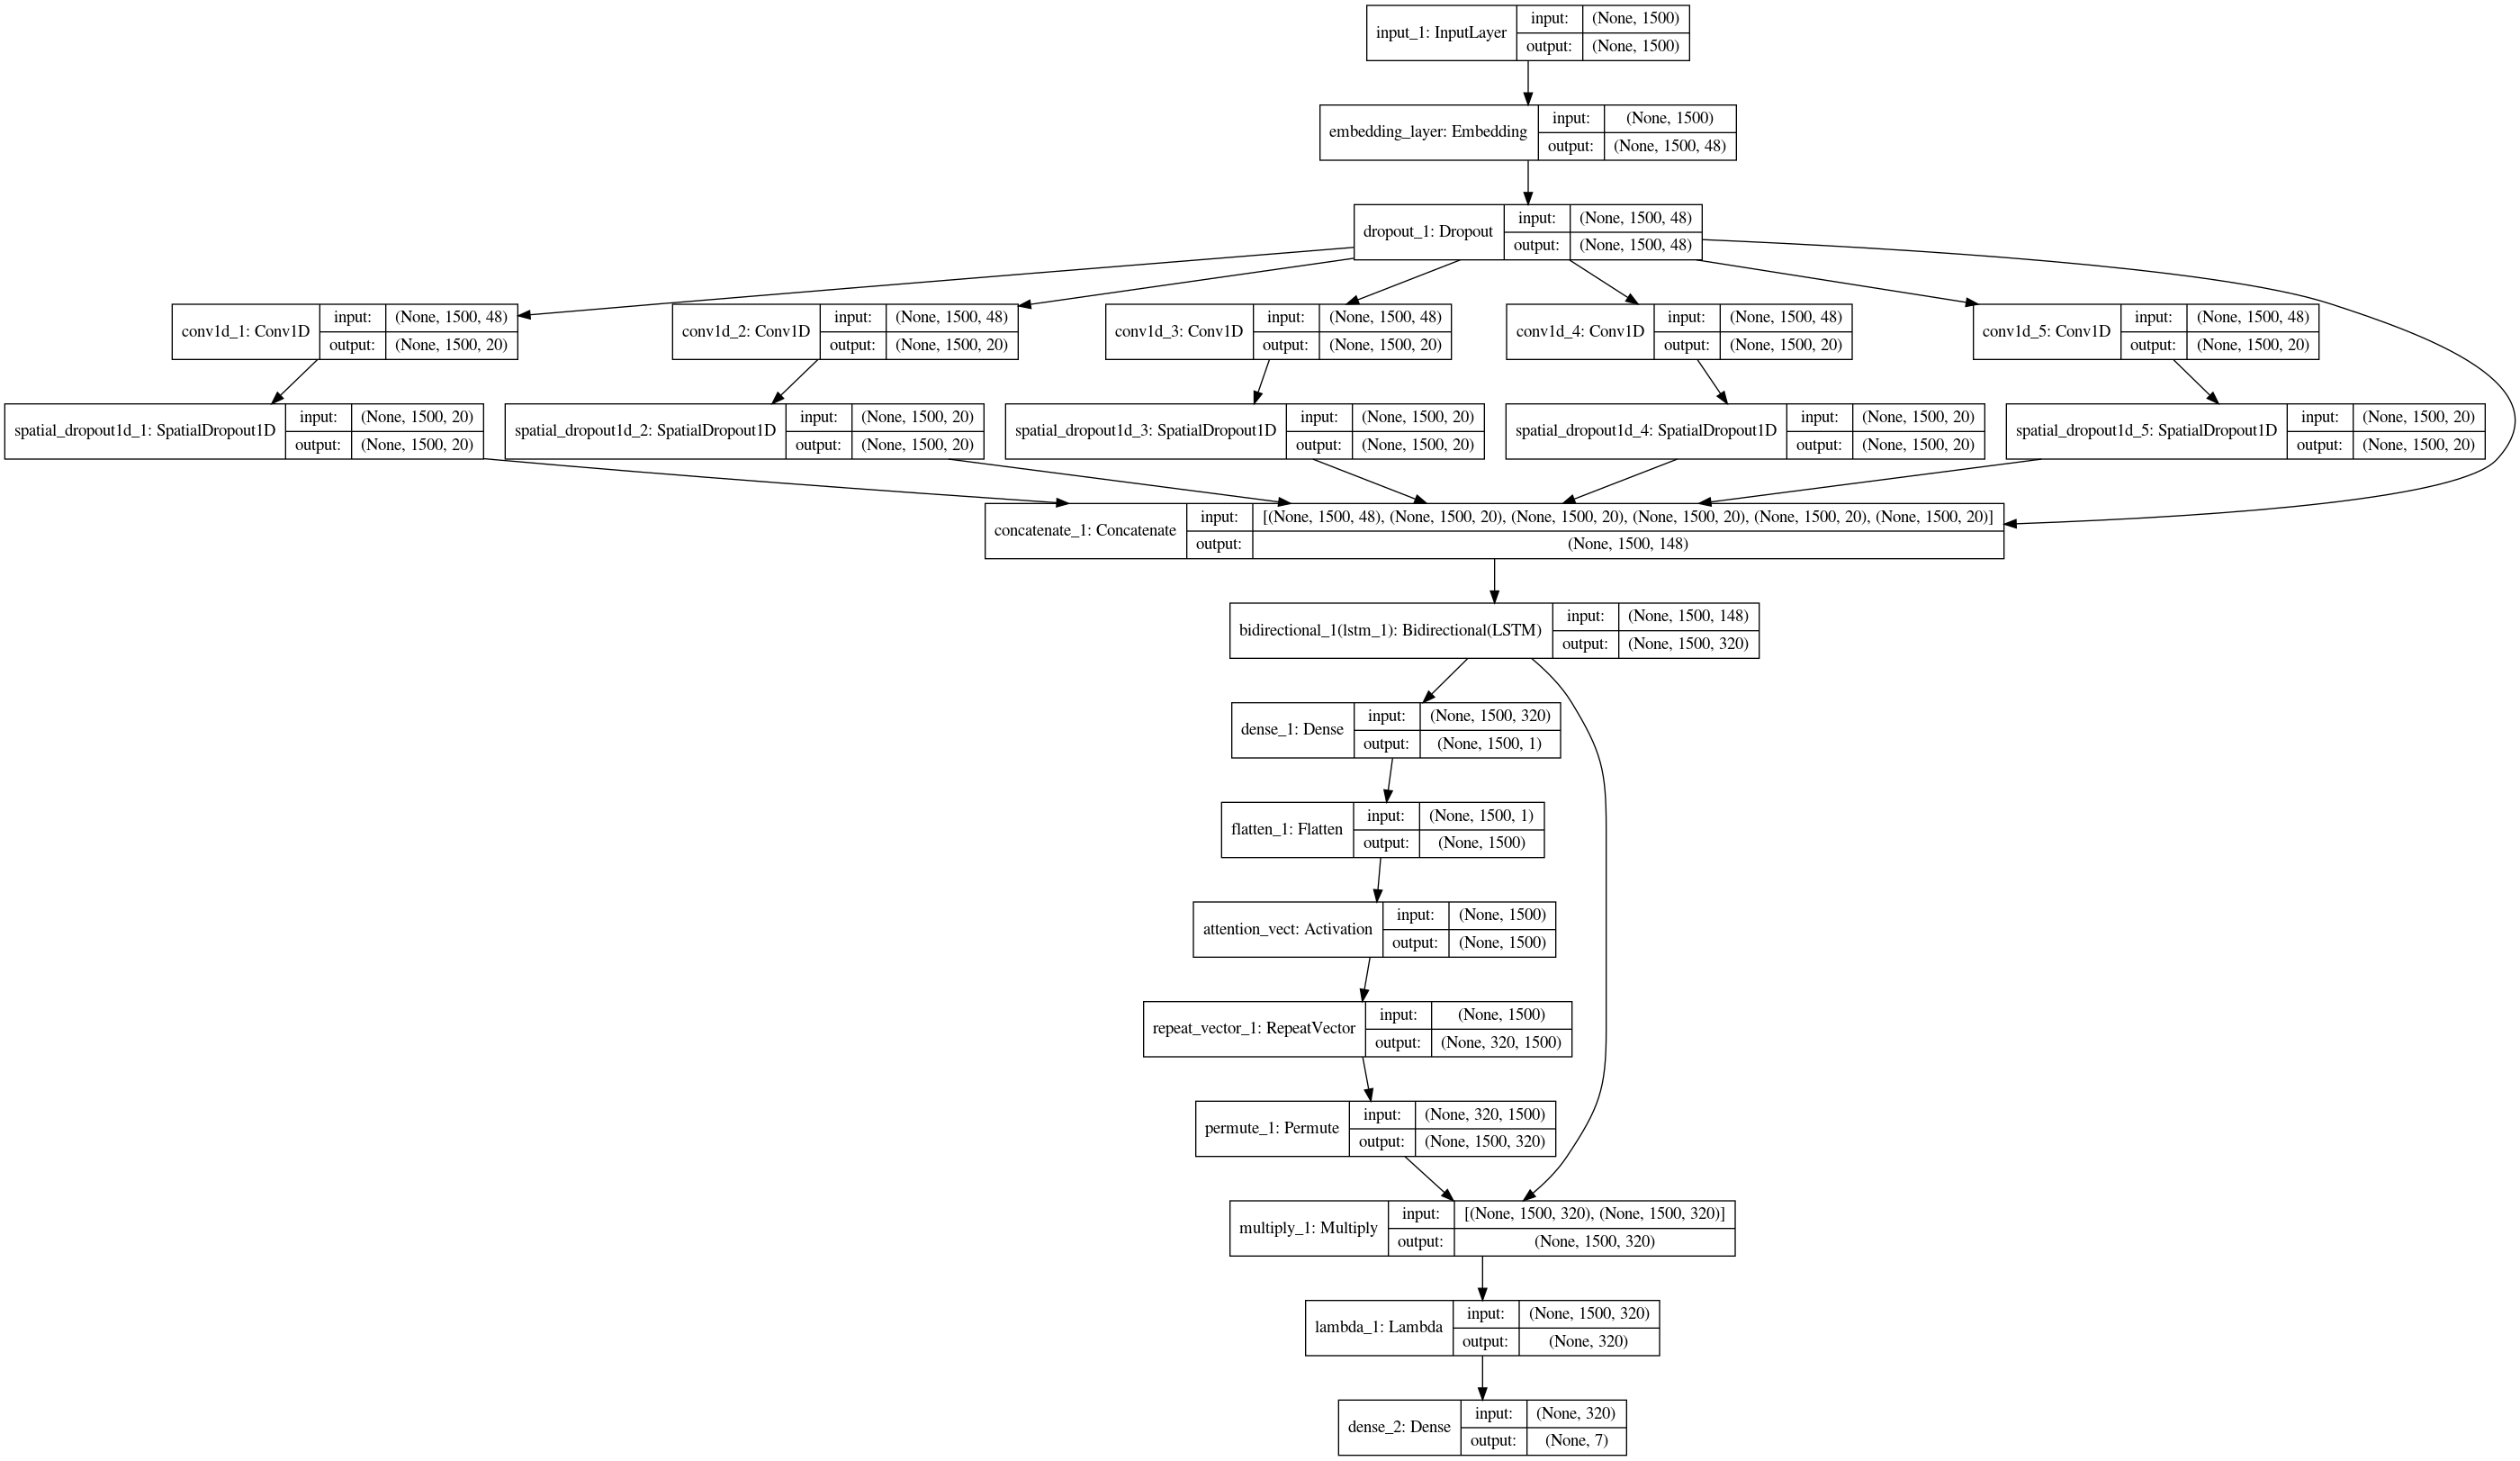

In [16]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model = Model(inputs=_input, outputs=probabilities)
plot_model(model, to_file='models/CNN_model2_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models/CNN_model2_weights.hdf5', 
                           verbose=1, save_best_only=True)
# Train, train, train
history = model.fit(x_train_pad, y_train_OH, 
                    batch_size=32, epochs=50,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Instructions for updating:
Use tf.cast instead.
Train on 2660 samples, validate on 666 samples
Epoch 1/50
2660/2660 [==============================] - 605s 227ms/step - loss: 1.4849 - accuracy: 0.5064 - val_loss: 1.3807 - val_accuracy: 0.5150

Epoch 00001: val_loss improved from inf to 1.38069, saving model to models/CNN_model2_weights.hdf5
Epoch 2/50
2660/2660 [==============================] - 521s 196ms/step - loss: 1.3672 - accuracy: 0.5365 - val_loss: 1.2981 - val_accuracy: 0.5601

Epoch 00002: val_loss improved from 1.38069 to 1.29815, saving model to models/CNN_model2_weights.hdf5
Epoch 3/50
2660/2660 [==============================] - 519s 195ms/step - loss: 1.2809 - accuracy: 0.5598 - val_loss: 1.2489 - val_accuracy: 0.6021

Epoch 00003: val_loss improved from 1.29815 to 1.24891, saving model to models/CNN_model2_weights.hdf5
Epoch 4/50
2660/2660 [==============================] - 515s 194ms/step - loss: 1.2205 - accuracy: 0.5898 - val_loss: 1.2048 - val_accuracy: 0.5901

Epoc

In [18]:
def history_plot(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()

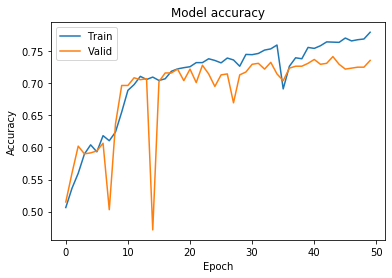

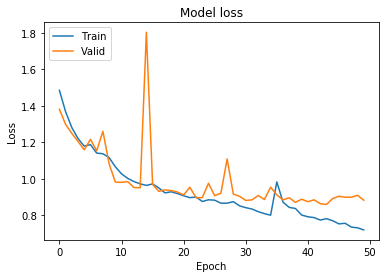

In [18]:
history_plot(history)

In [19]:
model2 = load_model('models/CNN_model2_weights.hdf5')
model2.evaluate(x_valid_pad, y_valid_OH)

666/666 [==============================] - 33s 50ms/step


[0.8600310391491955, 0.7417417168617249]

In [20]:
y_pred2 = model2.predict(x_valid_pad)
y_pred2_indices = OH_to_label_indices(y_pred2)
y_pred2_label = indices_to_cat(y_pred2_indices)

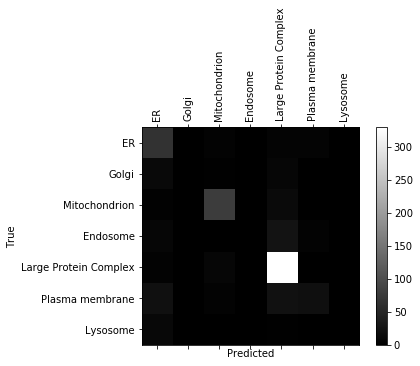

In [28]:
confusion_plot(y_valid, y_pred2_label, cat)

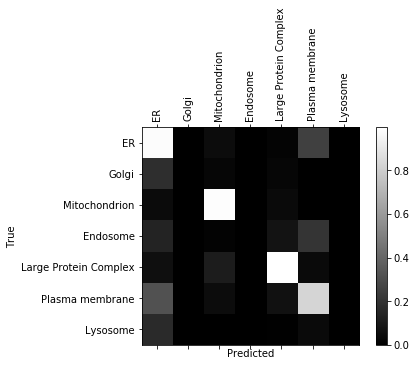

array([[ 65,   0,   4,   0,   6,   6,   0],
       [ 12,   0,   2,   0,   9,   0,   0],
       [  3,   0,  79,   0,  14,   0,   0],
       [  9,   0,   1,   0,  25,   5,   0],
       [  4,   0,   9,   0, 330,   1,   0],
       [ 21,   0,   4,   0,  23,  20,   0],
       [ 11,   0,   0,   0,   2,   1,   0]])

In [29]:
confusion_plot_norm(y_valid, y_pred2_label, cat, axis=1)

In [32]:
print(classification_report(y_valid, y_pred2_label))

                       precision    recall  f1-score   support

                   ER       0.52      0.80      0.63        81
             Endosome       0.00      0.00      0.00        40
                Golgi       0.00      0.00      0.00        23
Large Protein Complex       0.81      0.96      0.88       344
             Lysosome       0.00      0.00      0.00        14
        Mitochondrion       0.80      0.82      0.81        96
      Plasma membrane       0.61      0.29      0.40        68

             accuracy                           0.74       666
            macro avg       0.39      0.41      0.39       666
         weighted avg       0.66      0.74      0.69       666



# Model 3
Same CNN as model 1 but without MaxPool

In [33]:
max_features = tot_aa
batch_size = 32

#LSTM
units = 128
# Embedding
embedding_size = 48
# Convolution
filters = 20
pool_size = 2

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(input_dim=max_features,output_dim=embedding_size,
        input_length=max_len, name = 'embedding_layer', trainable=True, mask_zero=False)(_input)

drop = Dropout(0.2)(embedded)
# Convolution layer of different size

conv2 = Conv1D(filters, 2, padding='same', activation='relu', 
              strides=1)(drop)
drop2 = SpatialDropout1D(0.2)(conv2)
#pool2 = MaxPooling1D(pool_size=pool_size)(drop2)

conv3 = Conv1D(filters, 3, padding='same', activation='relu', 
              strides=1)(drop)
drop3 = SpatialDropout1D(0.2)(conv3)
#pool3 = MaxPooling1D(pool_size=pool_size)(drop3)

conv5 = Conv1D(filters, 5, padding='same', activation='relu', 
              strides=1)(drop)
drop5 = SpatialDropout1D(0.2)(conv5)
#pool5 = MaxPooling1D(pool_size=pool_size)(drop5)

conv9 = Conv1D(filters, 9, padding='same', activation='relu', 
              strides=1)(drop)
drop9 = SpatialDropout1D(0.2)(conv9)
#pool9 = MaxPooling1D(pool_size=pool_size)(drop9)

conv12 = Conv1D(filters, 12, padding='same', activation='relu', 
              strides=1)(drop)
drop12 = SpatialDropout1D(0.2)(conv12)
#pool12 = MaxPooling1D(pool_size=pool_size)(drop12)

conv16 = Conv1D(filters, 16, padding='same', activation='relu', 
              strides=1)(drop)
drop16 = SpatialDropout1D(0.2)(conv16)
#pool16 = MaxPooling1D(pool_size=pool_size)(drop16)

# Concatenate the filters
concat = concatenate([drop, drop2, drop3, drop5, drop9, drop12, drop16], axis=2)
#concat = concatenate([pool2, pool3, pool5, pool9, pool12, pool16], axis=2)

#pool = MaxPooling1D(pool_size=pool_size)(concat)

activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(concat)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(7, activation='softmax')(sent_representation)

model = Model(inputs=_input, outputs=probabilities)

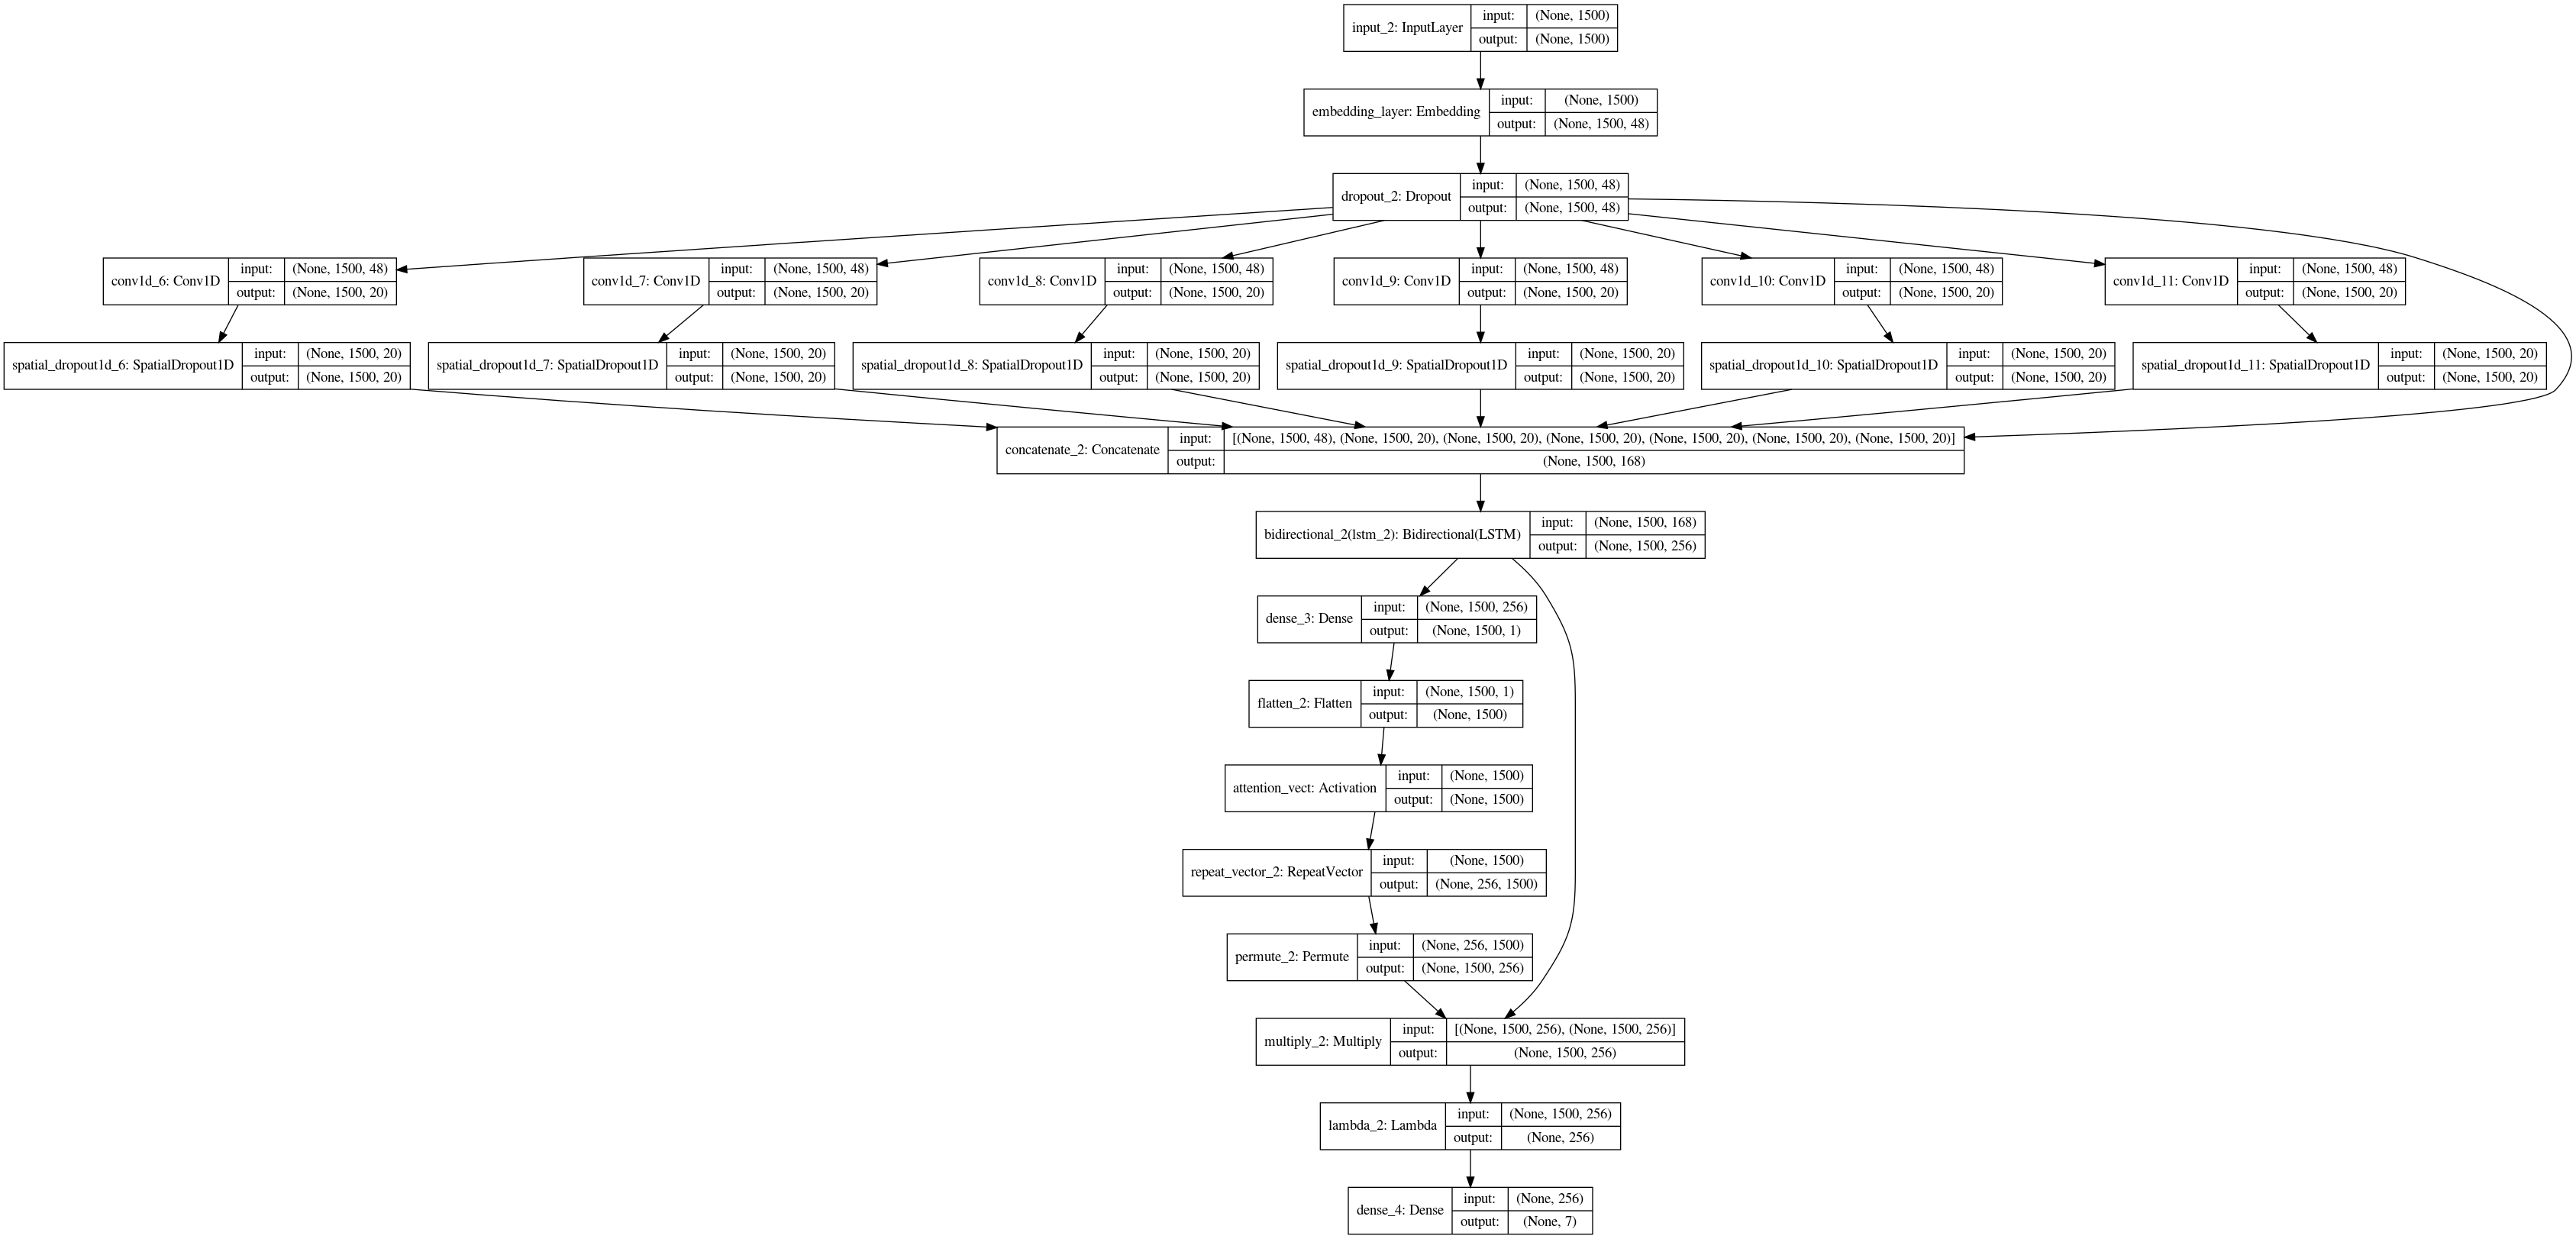

In [34]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model = Model(inputs=_input, outputs=probabilities)
plot_model(model, to_file='models/CNN_model3_plot.png', show_shapes=True, show_layer_names=True)

In [36]:
model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models/CNN_model3_weights.hdf5', 
                           verbose=1, save_best_only=True)
# Train, train, train
history2 = model.fit(x_train_pad, y_train_OH, 
                    batch_size=32, epochs=50,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Train on 2660 samples, validate on 666 samples
Epoch 1/50
2660/2660 [==============================] - 429s 161ms/step - loss: 1.4690 - accuracy: 0.5162 - val_loss: 1.4705 - val_accuracy: 0.5195

Epoch 00001: val_loss improved from inf to 1.47052, saving model to models/CNN_model2_weights.hdf5
Epoch 2/50
2660/2660 [==============================] - 403s 151ms/step - loss: 1.3565 - accuracy: 0.5387 - val_loss: 1.3292 - val_accuracy: 0.5480

Epoch 00002: val_loss improved from 1.47052 to 1.32920, saving model to models/CNN_model2_weights.hdf5
Epoch 3/50
2660/2660 [==============================] - 400s 150ms/step - loss: 1.2833 - accuracy: 0.5617 - val_loss: 1.8629 - val_accuracy: 0.4670

Epoch 00003: val_loss did not improve from 1.32920
Epoch 4/50
2660/2660 [==============================] - 401s 151ms/step - loss: 1.2492 - accuracy: 0.5677 - val_loss: 1.2051 - val_accuracy: 0.5946

Epoch 00004: val_loss improved from 1.32920 to 1.20510, saving model to models/CNN_model2_weights.hdf5
E

2660/2660 [==============================] - 400s 150ms/step - loss: 0.8598 - accuracy: 0.7368 - val_loss: 0.8740 - val_accuracy: 0.7192

Epoch 00037: val_loss did not improve from 0.86128
Epoch 38/50
2660/2660 [==============================] - 400s 150ms/step - loss: 0.8379 - accuracy: 0.7474 - val_loss: 0.8729 - val_accuracy: 0.7357

Epoch 00038: val_loss did not improve from 0.86128
Epoch 39/50
2660/2660 [==============================] - 400s 150ms/step - loss: 0.8250 - accuracy: 0.7470 - val_loss: 0.8609 - val_accuracy: 0.7297

Epoch 00039: val_loss improved from 0.86128 to 0.86092, saving model to models/CNN_model2_weights.hdf5
Epoch 40/50
2660/2660 [==============================] - 402s 151ms/step - loss: 0.8248 - accuracy: 0.7481 - val_loss: 0.8678 - val_accuracy: 0.7372

Epoch 00040: val_loss did not improve from 0.86092
Epoch 41/50
2660/2660 [==============================] - 401s 151ms/step - loss: 0.8231 - accuracy: 0.7477 - val_loss: 0.8781 - val_accuracy: 0.7357

Epoch 

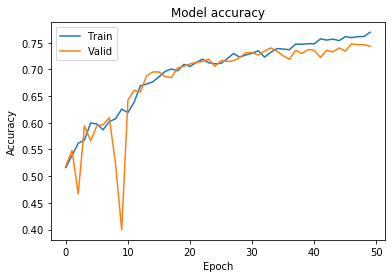

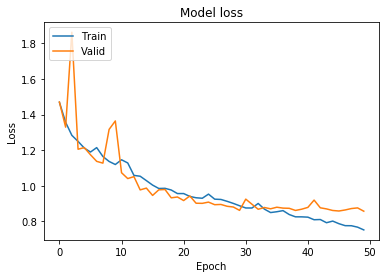

In [37]:
history_plot(history2)

In [21]:
model3 = load_model('models/CNN_model3_weights.hdf5')
model3.evaluate(x_valid_pad, y_valid_OH)

666/666 [==============================] - 27s 41ms/step


[0.8565896724437451, 0.7432432174682617]

In [39]:
y_pred3 = model3.predict(x_valid_pad)
y_pred3_indices = OH_to_label_indices(y_pred3)
y_pred3_label = indices_to_cat(y_pred3_indices)

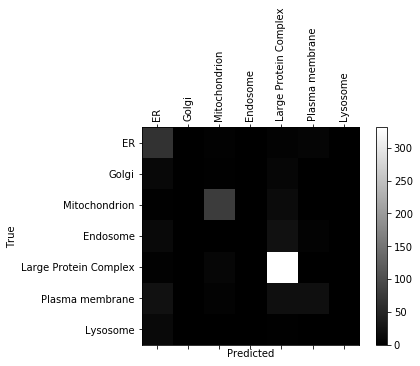

In [40]:
confusion_plot(y_valid, y_pred3_label, cat)

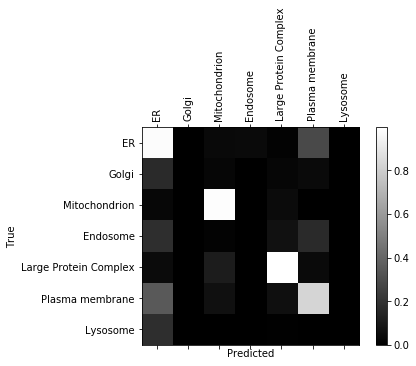

array([[ 65,   0,   3,   1,   5,   7,   0],
       [ 11,   0,   2,   0,   9,   1,   0],
       [  2,   0,  79,   0,  15,   0,   0],
       [ 12,   0,   1,   0,  23,   4,   0],
       [  3,   0,   9,   0, 331,   1,   0],
       [ 23,   0,   5,   0,  20,  20,   0],
       [ 12,   0,   0,   0,   2,   0,   0]])

In [41]:
confusion_plot_norm(y_valid, y_pred3_label, cat, axis=1)

In [42]:
print(classification_report(y_valid, y_pred3_label))

                       precision    recall  f1-score   support

                   ER       0.51      0.80      0.62        81
             Endosome       0.00      0.00      0.00        40
                Golgi       0.00      0.00      0.00        23
Large Protein Complex       0.82      0.96      0.88       344
             Lysosome       0.00      0.00      0.00        14
        Mitochondrion       0.80      0.82      0.81        96
      Plasma membrane       0.61      0.29      0.40        68

             accuracy                           0.74       666
            macro avg       0.39      0.41      0.39       666
         weighted avg       0.66      0.74      0.69       666



/home/julie/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model 4

In [45]:
model = load_model('models/model1_weights.hdf5')
embedding = model.get_layer('embedding_layer').get_weights()
embedding = embedding[0]
embedding.shape

(22, 48)

In [49]:
max_features = tot_aa
batch_size = 32

#LSTM
units = 128
# Embedding
embedding_size = 48
# Convolution
filters = 20
pool_size = 2

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(input_dim=max_features,output_dim=embedding_size,
        input_length=max_len, name = 'embedding_layer', weights = [embedding], 
        trainable=True, mask_zero=False)(_input)

drop = Dropout(0.2)(embedded)
# Convolution layer of different size

conv2 = Conv1D(filters, 2, padding='same', activation='relu', 
              strides=1)(drop)
drop2 = SpatialDropout1D(0.2)(conv2)
pool2 = MaxPooling1D(pool_size=pool_size)(drop2)

conv3 = Conv1D(filters, 3, padding='same', activation='relu', 
              strides=1)(drop)
drop3 = SpatialDropout1D(0.2)(conv3)
pool3 = MaxPooling1D(pool_size=pool_size)(drop3)

conv5 = Conv1D(filters, 5, padding='same', activation='relu', 
              strides=1)(drop)
drop5 = SpatialDropout1D(0.2)(conv5)
pool5 = MaxPooling1D(pool_size=pool_size)(drop5)

conv9 = Conv1D(filters, 9, padding='same', activation='relu', 
              strides=1)(drop)
drop9 = SpatialDropout1D(0.2)(conv9)
pool9 = MaxPooling1D(pool_size=pool_size)(drop9)

conv12 = Conv1D(filters, 12, padding='same', activation='relu', 
              strides=1)(drop)
drop12 = SpatialDropout1D(0.2)(conv12)
pool12 = MaxPooling1D(pool_size=pool_size)(drop12)

conv16 = Conv1D(filters, 16, padding='same', activation='relu', 
              strides=1)(drop)
drop16 = SpatialDropout1D(0.2)(conv16)
pool16 = MaxPooling1D(pool_size=pool_size)(drop16)

# Concatenate the filters
#concat = concatenate([drop2, drop3, drop5, drop9, drop12], axis=2)
concat = concatenate([pool2, pool3, pool5, pool9, pool12, pool16], axis=2)

#pool = MaxPooling1D(pool_size=pool_size)(concat)

activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(concat)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
pool = MaxPooling1D(pool_size=pool_size)(sent_representation)
lstm2 = Bidirectional(LSTM(units, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))(pool)

probabilities = Dense(7, activation='softmax')(lstm2)

model = Model(inputs=_input, outputs=probabilities)

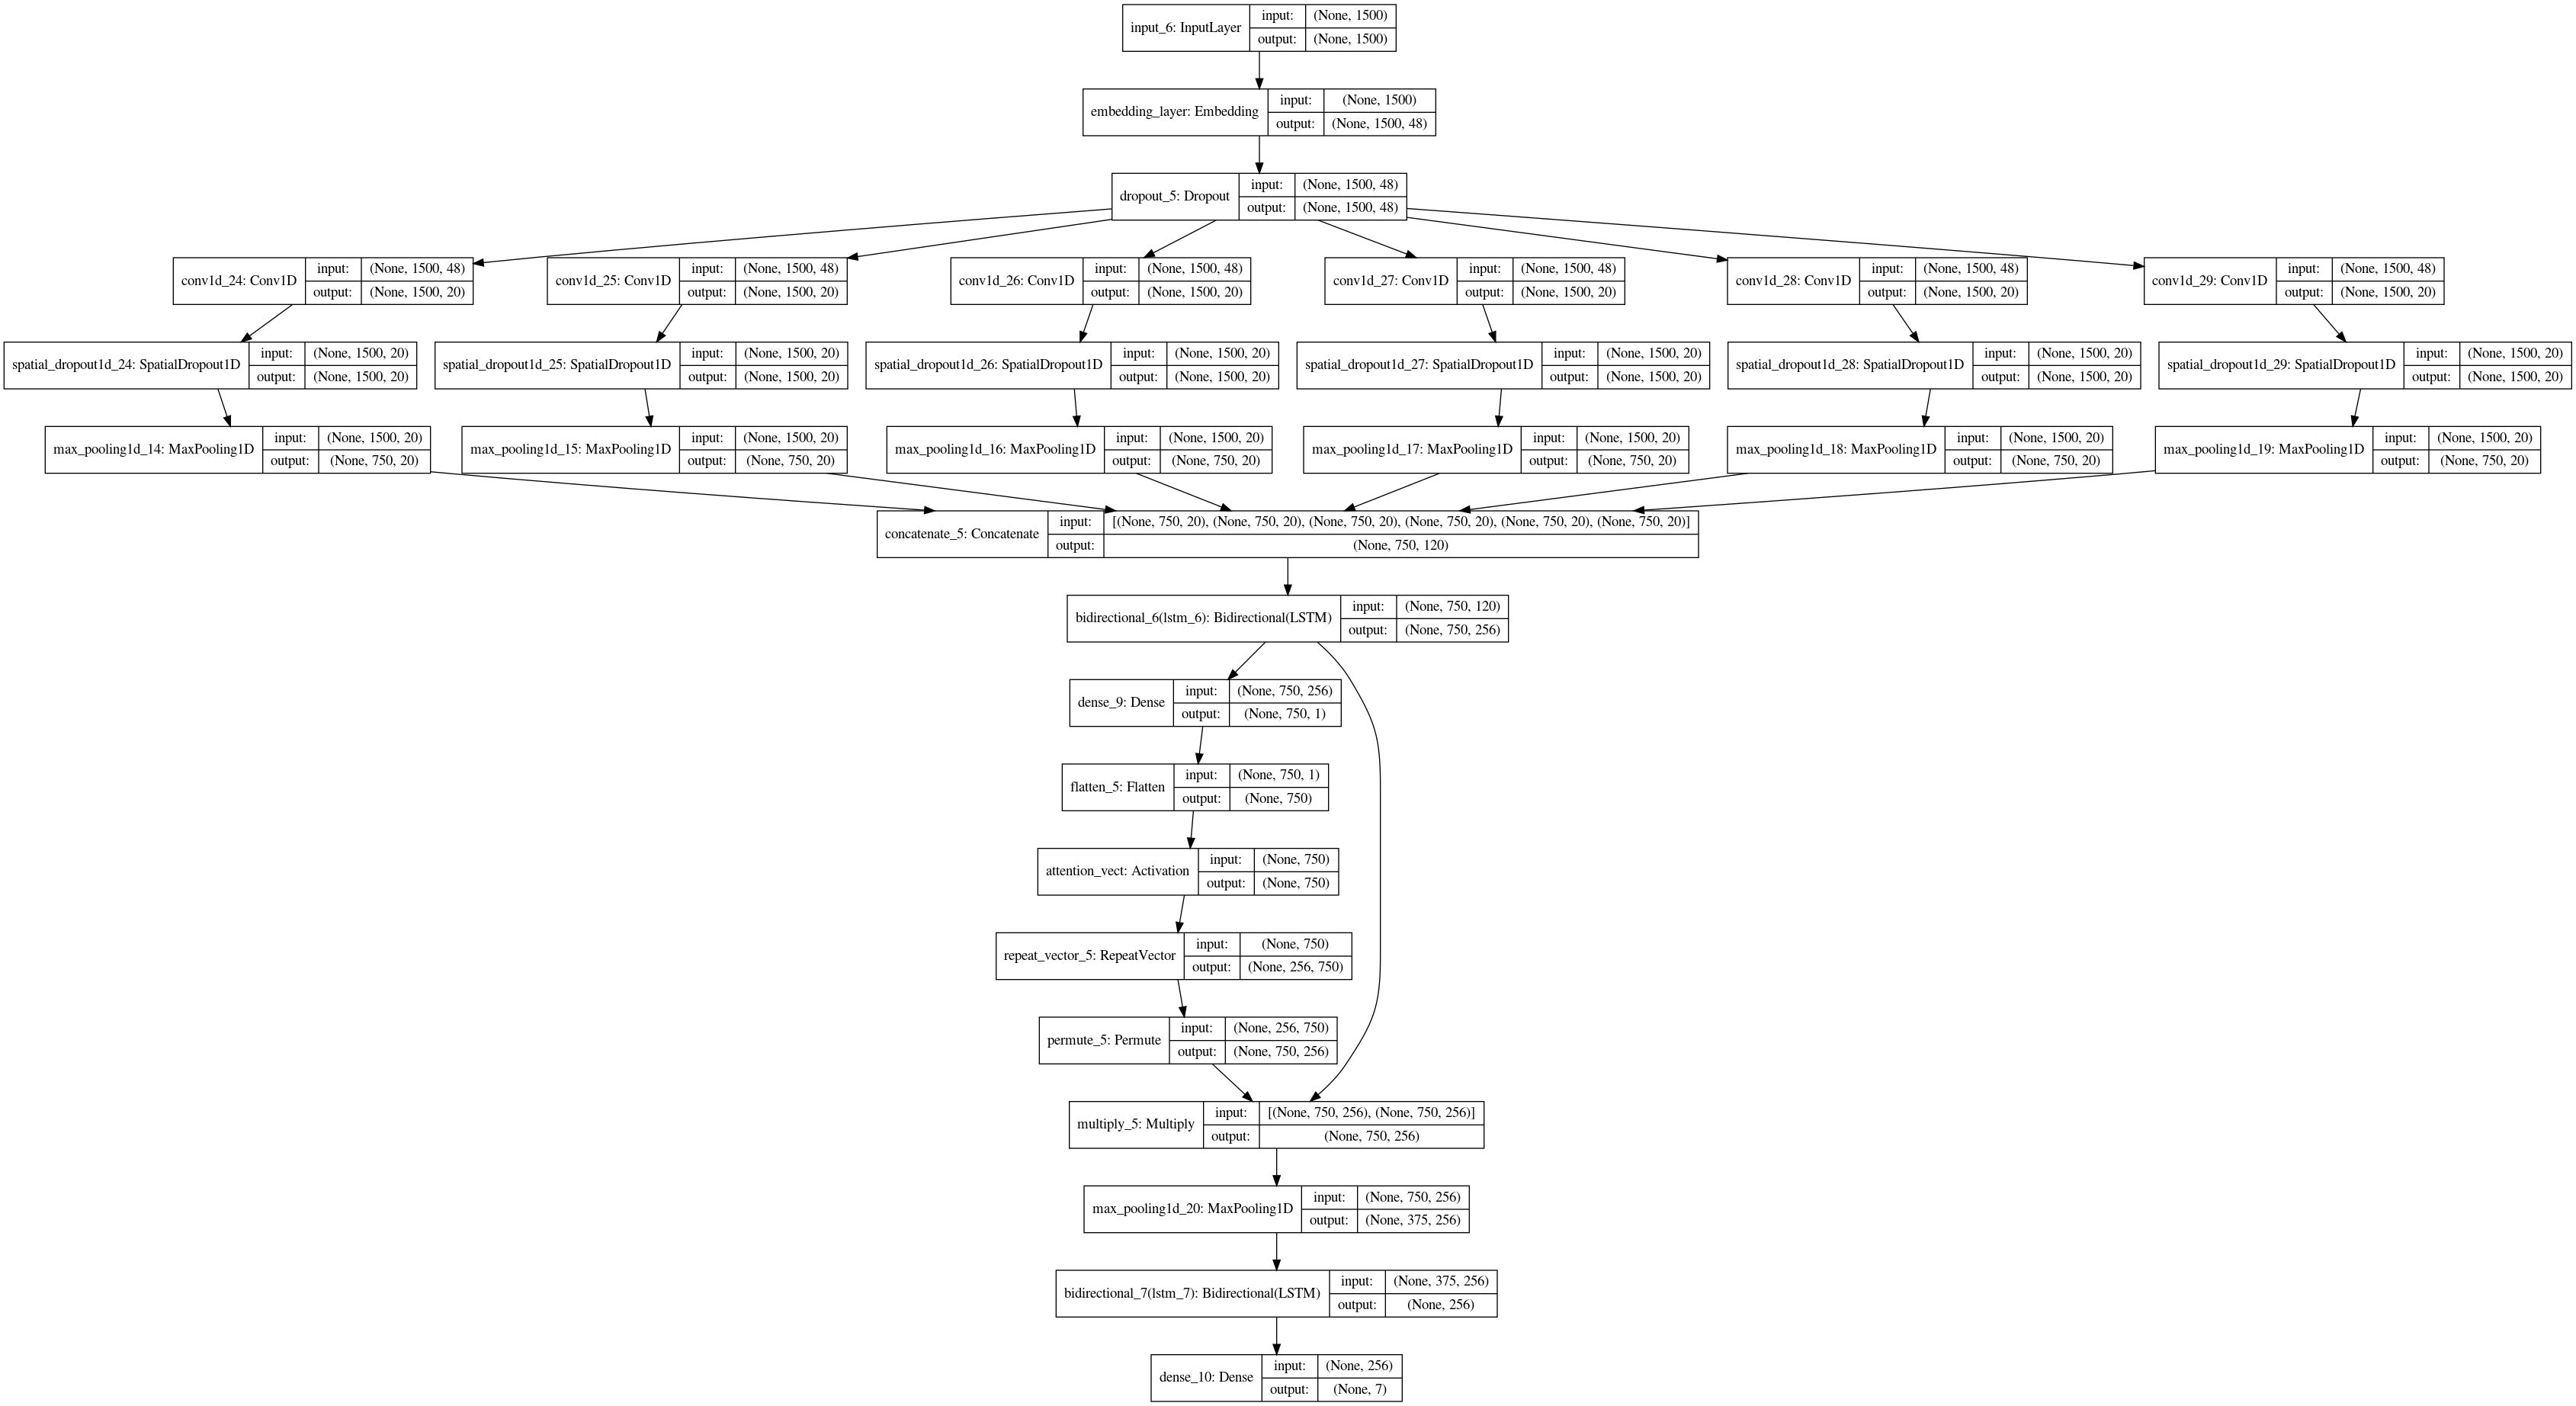

In [50]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model = Model(inputs=_input, outputs=probabilities)
plot_model(model, to_file='models/CNN_model4_plot.png', show_shapes=True, show_layer_names=True)

In [51]:
model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models/CNN_model4_weights.hdf5', 
                           verbose=1, save_best_only=True)
# Train, train, train
history4 = model.fit(x_train_pad, y_train_OH, 
                    batch_size=32, epochs=60,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Train on 2660 samples, validate on 666 samples
Epoch 1/60
2660/2660 [==============================] - 319s 120ms/step - loss: 1.5515 - accuracy: 0.5132 - val_loss: 1.5555 - val_accuracy: 0.5165

Epoch 00001: val_loss improved from inf to 1.55548, saving model to models/CNN_model4_weights.hdf5
Epoch 2/60
2660/2660 [==============================] - 329s 124ms/step - loss: 1.4865 - accuracy: 0.5158 - val_loss: 1.4929 - val_accuracy: 0.5165

Epoch 00002: val_loss improved from 1.55548 to 1.49291, saving model to models/CNN_model4_weights.hdf5
Epoch 3/60
2660/2660 [==============================] - 334s 126ms/step - loss: 1.4778 - accuracy: 0.5158 - val_loss: 1.4722 - val_accuracy: 0.5165

Epoch 00003: val_loss improved from 1.49291 to 1.47219, saving model to models/CNN_model4_weights.hdf5
Epoch 4/60
2660/2660 [==============================] - 316s 119ms/step - loss: 1.4571 - accuracy: 0.5158 - val_loss: 1.4662 - val_accuracy: 0.5150

Epoch 00004: val_loss improved from 1.47219 to 1.466

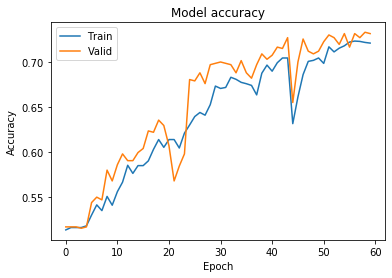

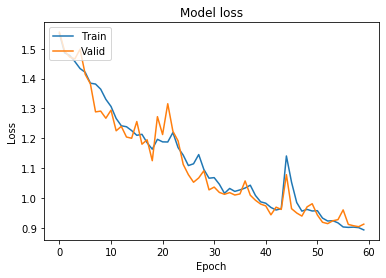

In [52]:
history_plot(history4)

In [56]:
# Keep training that model
model = load_model('models/CNN_model4_weights.hdf5')
model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models/CNN_model4_2_weights.hdf5', 
                           verbose=1, save_best_only=True)
history4 = model.fit(x_train_pad, y_train_OH, 
                    batch_size=32, epochs=30,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Train on 2660 samples, validate on 666 samples
Epoch 1/30
2660/2660 [==============================] - 333s 125ms/step - loss: 1.1642 - accuracy: 0.6624 - val_loss: 1.0218 - val_accuracy: 0.6967

Epoch 00001: val_loss improved from inf to 1.02176, saving model to models/CNN_model4_2_weights.hdf5
Epoch 2/30
2660/2660 [==============================] - 355s 134ms/step - loss: 0.9486 - accuracy: 0.7117 - val_loss: 0.9258 - val_accuracy: 0.7102

Epoch 00002: val_loss improved from 1.02176 to 0.92575, saving model to models/CNN_model4_2_weights.hdf5
Epoch 3/30
2660/2660 [==============================] - 318s 120ms/step - loss: 0.8917 - accuracy: 0.7289 - val_loss: 0.8890 - val_accuracy: 0.7327

Epoch 00003: val_loss improved from 0.92575 to 0.88902, saving model to models/CNN_model4_2_weights.hdf5
Epoch 4/30
2660/2660 [==============================] - 314s 118ms/step - loss: 0.8816 - accuracy: 0.7297 - val_loss: 0.8858 - val_accuracy: 0.7357

Epoch 00004: val_loss improved from 0.88902 to

In [25]:
model4 = load_model('models/CNN_model4_weights.hdf5')
model4.evaluate(x_valid_pad, y_valid_OH)

666/666 [==============================] - 32s 48ms/step


[0.903884805358566, 0.7327327132225037]

In [24]:
y_pred4 = model4.predict(x_valid_pad)
y_pred4_indices = OH_to_label_indices(y_pred4)
y_pred4_label = indices_to_cat(y_pred4_indices)

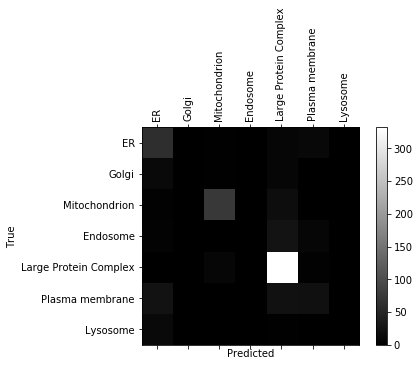

In [68]:
confusion_plot(y_valid, y_pred4_label, cat)

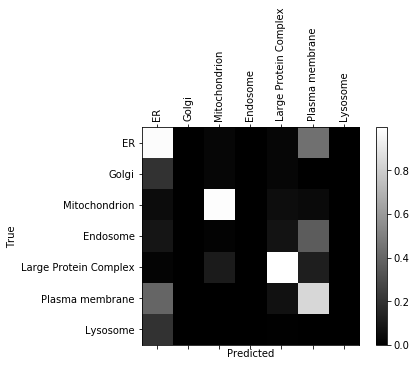

array([[ 60,   0,   2,   0,   8,  11,   0],
       [ 12,   0,   2,   0,   9,   0,   0],
       [  3,   0,  75,   0,  17,   1,   0],
       [  5,   0,   1,   0,  25,   9,   0],
       [  1,   0,   8,   0, 332,   3,   0],
       [ 24,   0,   0,   0,  23,  21,   0],
       [ 12,   0,   0,   0,   2,   0,   0]])

In [67]:
confusion_plot_norm(y_valid, y_pred4_label, cat, axis=1)

In [57]:
model4 = load_model('models/CNN_model4_2_weights.hdf5')
y_pred4 = model4.predict(x_valid_pad)
y_pred4_indices = OH_to_label_indices(y_pred4)
y_pred4_label = indices_to_cat(y_pred4_indices)

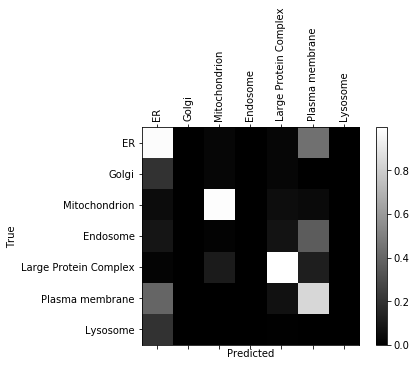

array([[ 60,   0,   2,   0,   8,  11,   0],
       [ 12,   0,   2,   0,   9,   0,   0],
       [  3,   0,  75,   0,  17,   1,   0],
       [  5,   0,   1,   0,  25,   9,   0],
       [  1,   0,   8,   0, 332,   3,   0],
       [ 24,   0,   0,   0,  23,  21,   0],
       [ 12,   0,   0,   0,   2,   0,   0]])

In [66]:
confusion_plot_norm(y_valid, y_pred4_label, cat, axis=1)

In [26]:
print(classification_report(y_valid, y_pred4_label))

                       precision    recall  f1-score   support

                   ER       0.49      0.77      0.60        81
             Endosome       0.00      0.00      0.00        40
                Golgi       0.00      0.00      0.00        23
Large Protein Complex       0.80      0.98      0.88       344
             Lysosome       0.00      0.00      0.00        14
        Mitochondrion       0.81      0.80      0.81        96
      Plasma membrane       0.59      0.19      0.29        68

             accuracy                           0.73       666
            macro avg       0.38      0.39      0.37       666
         weighted avg       0.65      0.73      0.67       666



/home/julie/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model 5

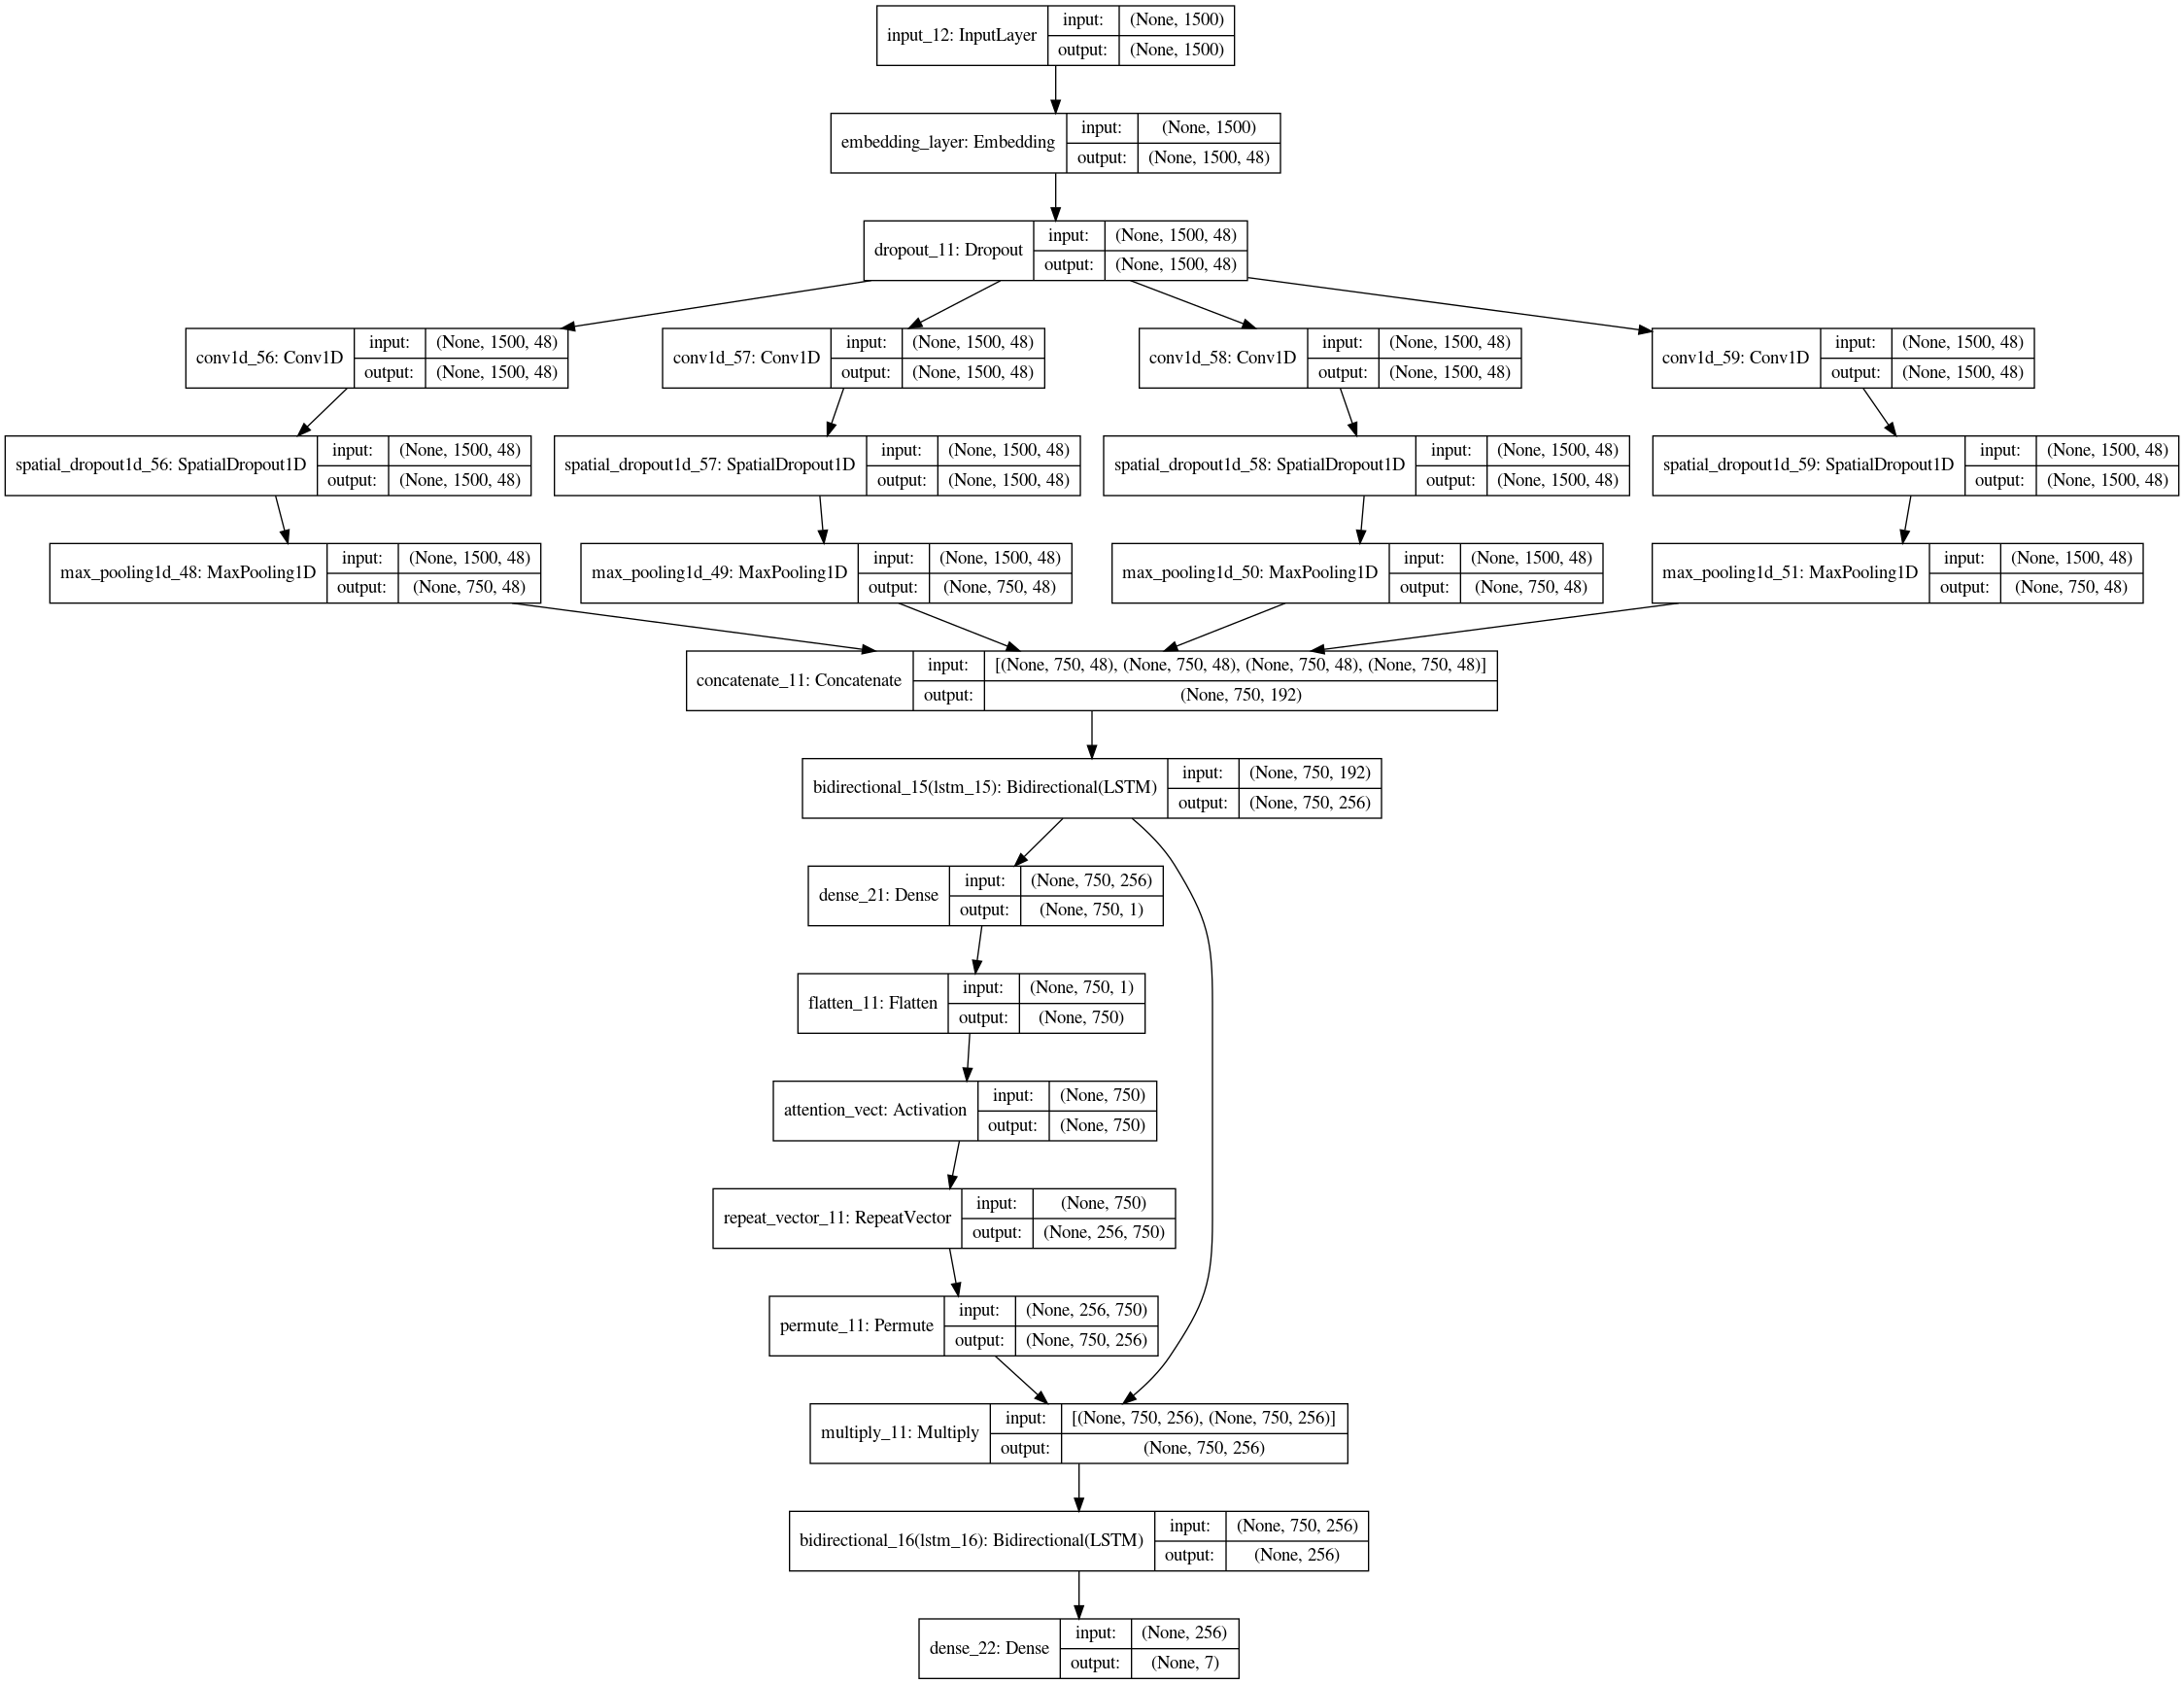

In [73]:
max_features = tot_aa
batch_size = 32

#LSTM
units = 128
# Embedding
embedding_size = 48
# Convolution
filters = 48
pool_size = 2

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(input_dim=max_features,output_dim=embedding_size,
        input_length=max_len, name = 'embedding_layer', weights = [embedding], 
        trainable=True, mask_zero=False)(_input)

drop = Dropout(0.2)(embedded)
# Convolution layer of different size

#conv2 = Conv1D(filters, 2, padding='same', activation='relu', 
#              strides=1)(drop)
#drop2 = SpatialDropout1D(0.2)(conv2)
#pool2 = MaxPooling1D(pool_size=pool_size)(drop2)

conv3 = Conv1D(filters, 3, padding='same', activation='relu', 
              strides=1)(drop)
drop3 = SpatialDropout1D(0.2)(conv3)
pool3 = MaxPooling1D(pool_size=pool_size)(drop3)

conv5 = Conv1D(filters, 5, padding='same', activation='relu', 
              strides=1)(drop)
drop5 = SpatialDropout1D(0.2)(conv5)
pool5 = MaxPooling1D(pool_size=pool_size)(drop5)

conv9 = Conv1D(filters, 9, padding='same', activation='relu', 
              strides=1)(drop)
drop9 = SpatialDropout1D(0.2)(conv9)
pool9 = MaxPooling1D(pool_size=pool_size)(drop9)

conv12 = Conv1D(filters, 12, padding='same', activation='relu', 
              strides=1)(drop)
drop12 = SpatialDropout1D(0.2)(conv12)
pool12 = MaxPooling1D(pool_size=pool_size)(drop12)

#conv16 = Conv1D(filters, 16, padding='same', activation='relu', 
#              strides=1)(drop)
#drop16 = SpatialDropout1D(0.2)(conv16)
#pool16 = MaxPooling1D(pool_size=pool_size)(drop16)

# Concatenate the filters
#concat = concatenate([drop2, drop3, drop5, drop9, drop12], axis=2)
concat = concatenate([pool3, pool5, pool9, pool12], axis=2)

#pool = MaxPooling1D(pool_size=pool_size)(concat)

activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(concat)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
#pool = MaxPooling1D(pool_size=pool_size)(sent_representation)
lstm2 = Bidirectional(LSTM(units, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))(sent_representation)

probabilities = Dense(7, activation='softmax')(lstm2)

model = Model(inputs=_input, outputs=probabilities)

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model = Model(inputs=_input, outputs=probabilities)
plot_model(model, to_file='models/CNN_model5_plot.png', show_shapes=True, show_layer_names=True)

In [63]:
model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models/CNN_model5_weights.hdf5', 
                           verbose=1, save_best_only=True)
# Train, train, train
history4 = model.fit(x_train_pad, y_train_OH, 
                    batch_size=32, epochs=80,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Train on 2660 samples, validate on 666 samples
Epoch 1/80
2660/2660 [==============================] - 454s 171ms/step - loss: 1.5272 - accuracy: 0.5120 - val_loss: 1.5002 - val_accuracy: 0.5165

Epoch 00001: val_loss improved from inf to 1.50017, saving model to models/CNN_model5_weights.hdf5
Epoch 2/80
2660/2660 [==============================] - 469s 176ms/step - loss: 1.4837 - accuracy: 0.5158 - val_loss: 1.5135 - val_accuracy: 0.5165

Epoch 00002: val_loss did not improve from 1.50017
Epoch 3/80
2660/2660 [==============================] - 432s 162ms/step - loss: 1.4773 - accuracy: 0.5158 - val_loss: 1.4690 - val_accuracy: 0.5165

Epoch 00003: val_loss improved from 1.50017 to 1.46901, saving model to models/CNN_model5_weights.hdf5
Epoch 4/80
2660/2660 [==============================] - 431s 162ms/step - loss: 1.4618 - accuracy: 0.5158 - val_loss: 1.4625 - val_accuracy: 0.5165

Epoch 00004: val_loss improved from 1.46901 to 1.46247, saving model to models/CNN_model5_weights.hdf5
E


Epoch 00037: val_loss did not improve from 0.97337
Epoch 38/80
2660/2660 [==============================] - 431s 162ms/step - loss: 0.8315 - accuracy: 0.7466 - val_loss: 1.2682 - val_accuracy: 0.5976

Epoch 00038: val_loss did not improve from 0.97337
Epoch 39/80
2660/2660 [==============================] - 430s 162ms/step - loss: 0.8137 - accuracy: 0.7579 - val_loss: 0.9710 - val_accuracy: 0.7162

Epoch 00039: val_loss improved from 0.97337 to 0.97095, saving model to models/CNN_model5_weights.hdf5
Epoch 40/80
2660/2660 [==============================] - 433s 163ms/step - loss: 0.8061 - accuracy: 0.7598 - val_loss: 0.9771 - val_accuracy: 0.7117

Epoch 00040: val_loss did not improve from 0.97095
Epoch 41/80
2660/2660 [==============================] - 432s 163ms/step - loss: 0.7961 - accuracy: 0.7620 - val_loss: 0.9868 - val_accuracy: 0.7282

Epoch 00041: val_loss did not improve from 0.97095
Epoch 42/80
2660/2660 [==============================] - 432s 163ms/step - loss: 0.7534 - ac

2660/2660 [==============================] - 428s 161ms/step - loss: 0.5352 - accuracy: 0.8353 - val_loss: 1.1625 - val_accuracy: 0.7147

Epoch 00078: val_loss did not improve from 0.96863
Epoch 79/80
2660/2660 [==============================] - 426s 160ms/step - loss: 0.5292 - accuracy: 0.8372 - val_loss: 1.8740 - val_accuracy: 0.4820

Epoch 00079: val_loss did not improve from 0.96863
Epoch 80/80
2660/2660 [==============================] - 426s 160ms/step - loss: 0.5183 - accuracy: 0.8398 - val_loss: 1.3381 - val_accuracy: 0.6667

Epoch 00080: val_loss did not improve from 0.96863


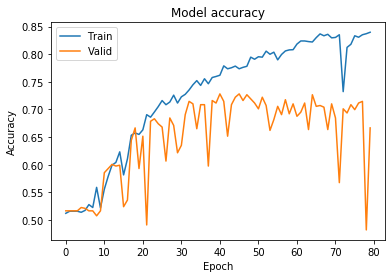

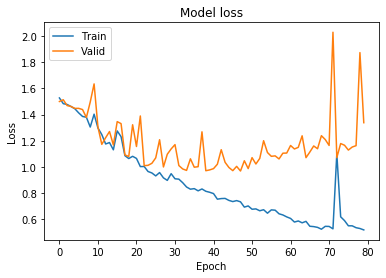

In [64]:
history_plot(history4)

In [27]:
model5 = load_model('models/CNN_model5_weights.hdf5')
y_pred5 = model5.predict(x_valid_pad)
y_pred5_indices = OH_to_label_indices(y_pred5)
y_pred5_label = indices_to_cat(y_pred5_indices)

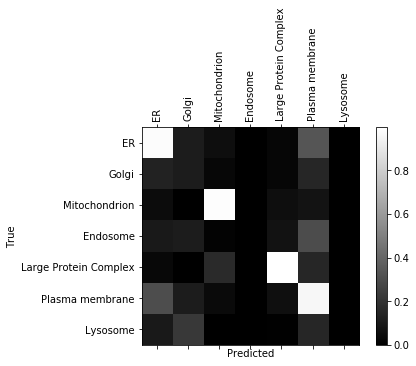

array([[ 59,   1,   4,   0,   8,   9,   0],
       [  8,   1,   2,   0,   8,   4,   0],
       [  3,   0,  72,   0,  19,   2,   0],
       [  6,   1,   1,   0,  24,   8,   0],
       [  2,   0,  12,   0, 326,   4,   0],
       [ 18,   1,   3,   0,  20,  26,   0],
       [  6,   2,   0,   0,   2,   4,   0]])

In [69]:
confusion_plot_norm(y_valid, y_pred5_label, cat, axis=1)

In [29]:
model5.evaluate(x_valid_pad, y_valid_OH)

666/666 [==============================] - 31s 47ms/step


[0.9686259697149465, 0.7267267107963562]

In [28]:
print(classification_report(y_valid, y_pred5_label))

                       precision    recall  f1-score   support

                   ER       0.58      0.73      0.64        81
             Endosome       0.00      0.00      0.00        40
                Golgi       0.17      0.04      0.07        23
Large Protein Complex       0.80      0.95      0.87       344
             Lysosome       0.00      0.00      0.00        14
        Mitochondrion       0.77      0.75      0.76        96
      Plasma membrane       0.46      0.38      0.42        68

             accuracy                           0.73       666
            macro avg       0.40      0.41      0.39       666
         weighted avg       0.65      0.73      0.68       666



# Model 6
Going back to the first model

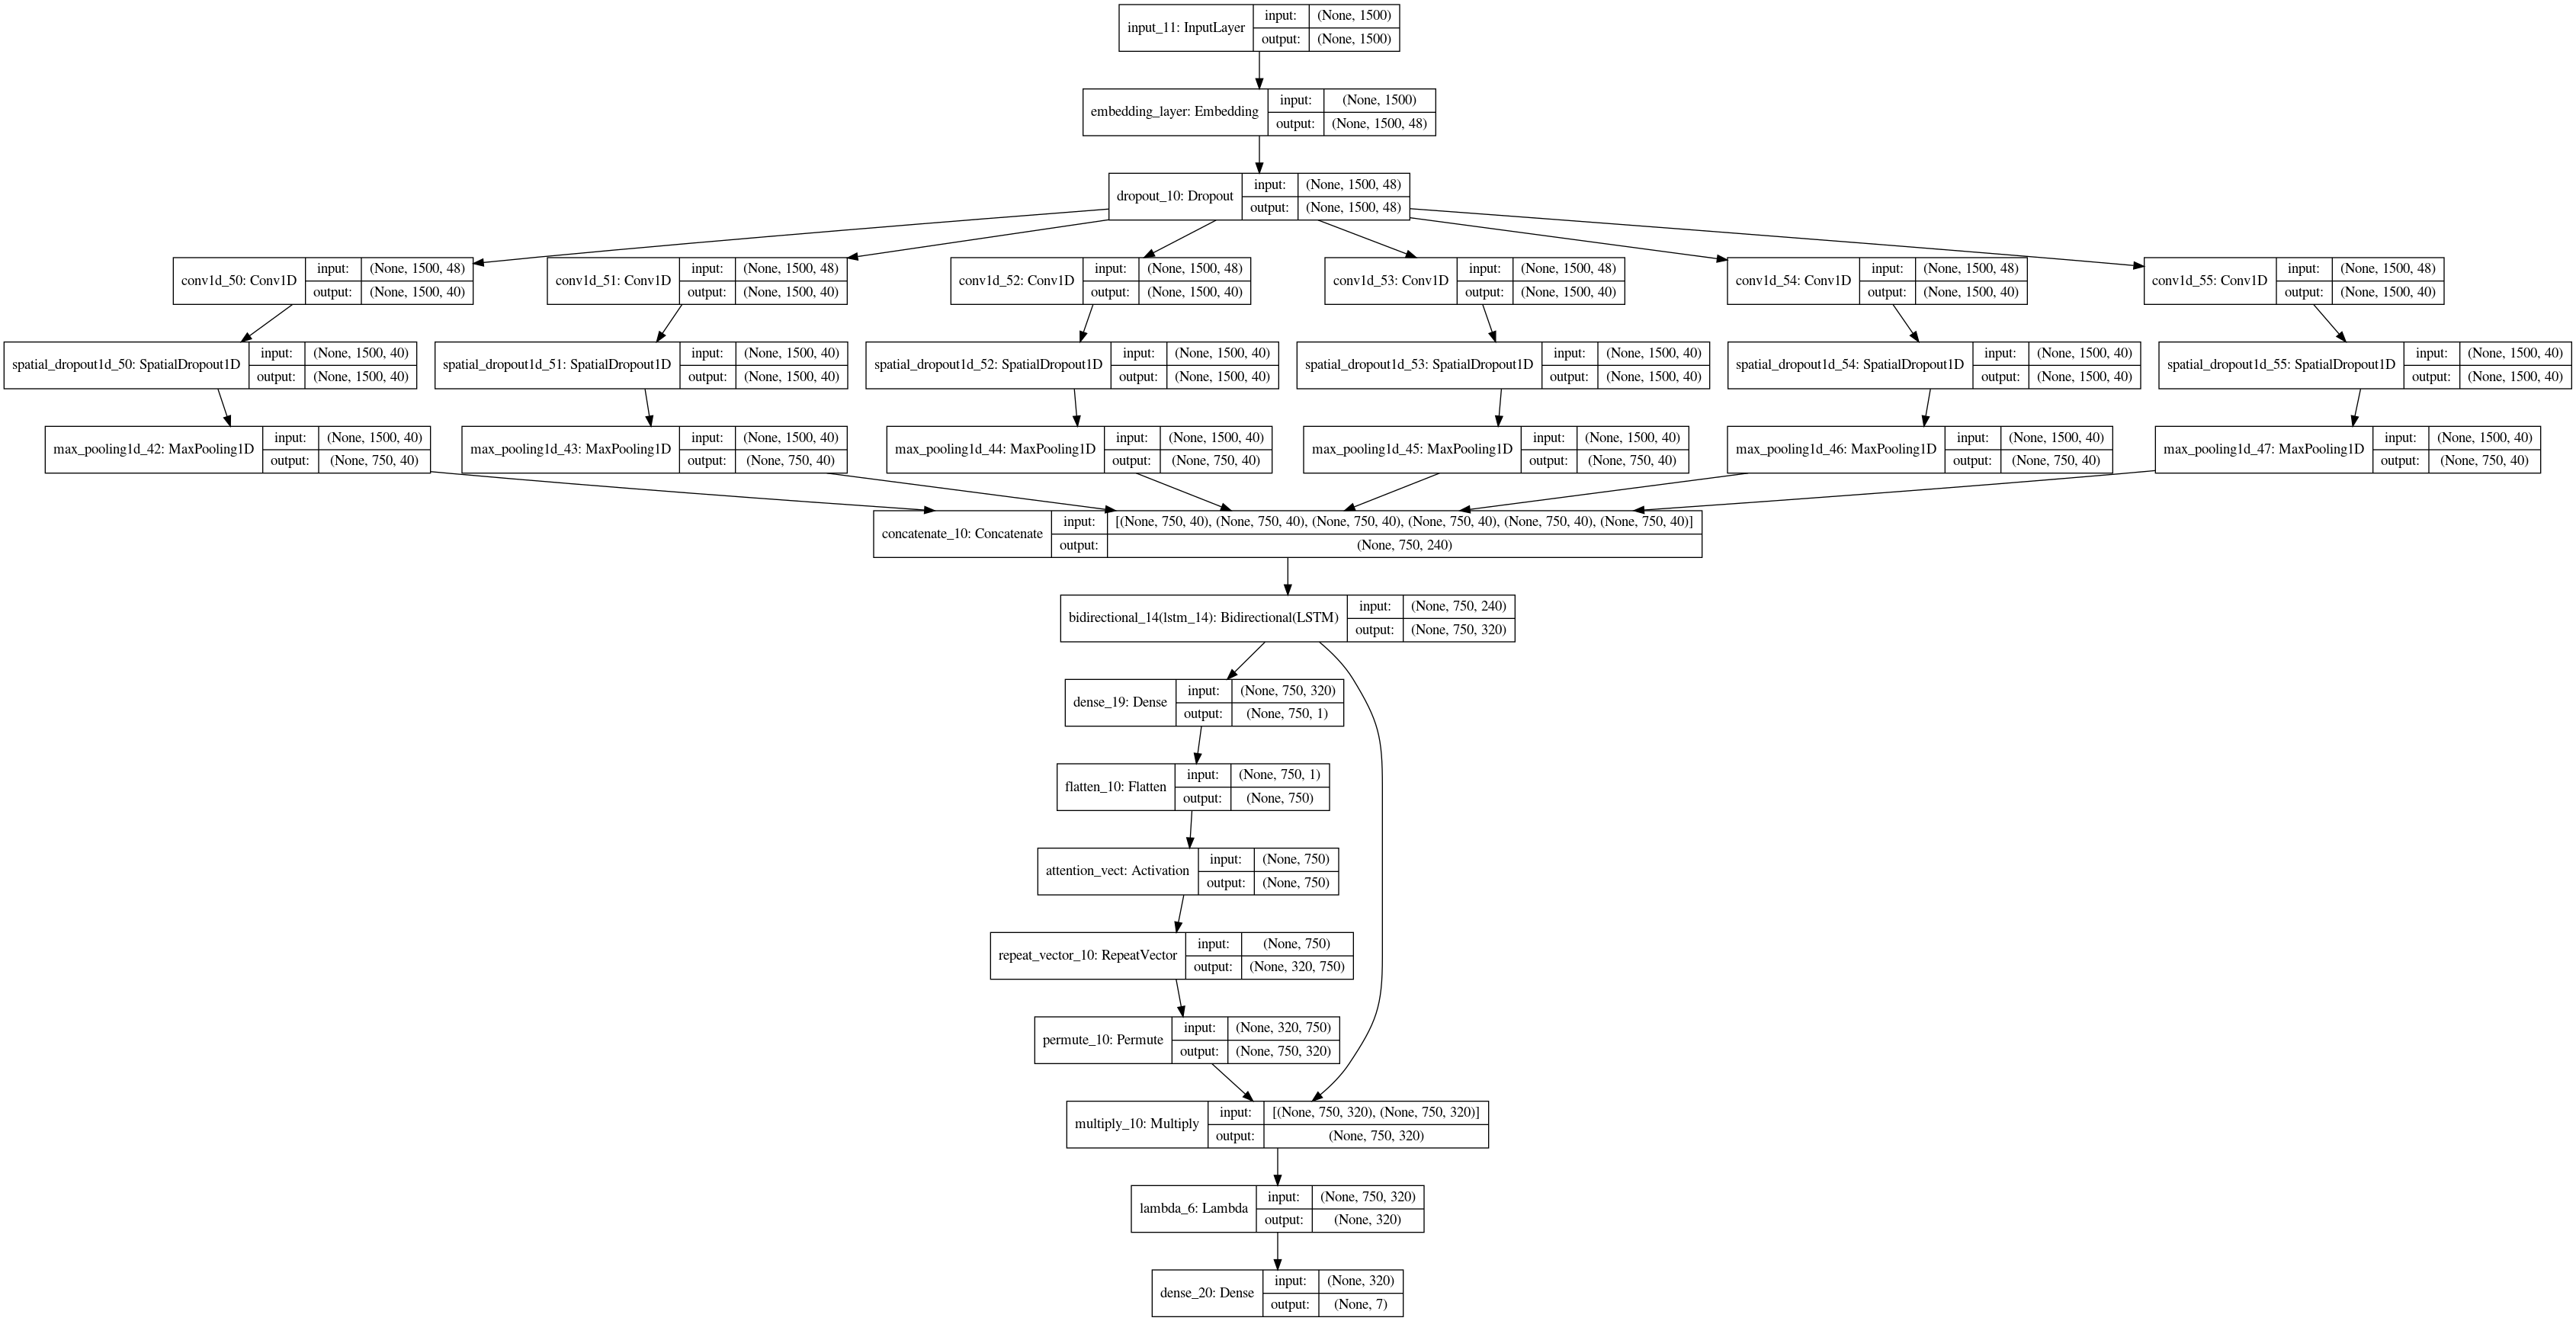

In [72]:
max_features = tot_aa
batch_size = 32

#LSTM
units = 160
# Embedding
embedding_size = 48
# Convolution
filters = 40
pool_size = 2

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(input_dim=max_features,output_dim=embedding_size,
        input_length=max_len, weights=[embedding], name = 'embedding_layer', trainable=True, mask_zero=False)(_input)

drop = Dropout(0.2)(embedded)
# Convolution layer of different size

conv2 = Conv1D(filters, 2, padding='same', activation='relu', 
              strides=1)(drop)
drop2 = SpatialDropout1D(0.2)(conv2)
pool2 = MaxPooling1D(pool_size=pool_size)(drop2)

conv3 = Conv1D(filters, 3, padding='same', activation='relu', 
              strides=1)(drop)
drop3 = SpatialDropout1D(0.2)(conv3)
pool3 = MaxPooling1D(pool_size=pool_size)(drop3)

conv5 = Conv1D(filters, 5, padding='same', activation='relu', 
              strides=1)(drop)
drop5 = SpatialDropout1D(0.2)(conv5)
pool5 = MaxPooling1D(pool_size=pool_size)(drop5)

conv9 = Conv1D(filters, 9, padding='same', activation='relu', 
              strides=1)(drop)
drop9 = SpatialDropout1D(0.2)(conv9)
pool9 = MaxPooling1D(pool_size=pool_size)(drop9)

conv12 = Conv1D(filters, 12, padding='same', activation='relu', 
              strides=1)(drop)
drop12 = SpatialDropout1D(0.2)(conv12)
pool12 = MaxPooling1D(pool_size=pool_size)(drop12)

conv16 = Conv1D(filters, 16, padding='same', activation='relu', 
              strides=1)(drop)
drop16 = SpatialDropout1D(0.2)(conv16)
pool16 = MaxPooling1D(pool_size=pool_size)(drop16)

# Concatenate the filters
#concat = concatenate([drop2, drop3, drop5, drop9, drop12], axis=2)
concat = concatenate([pool2, pool3, pool5, pool9, pool12, pool16], axis=2)

#pool = MaxPooling1D(pool_size=pool_size)(concat)

activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(concat)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(7, activation='softmax')(sent_representation)

model = Model(inputs=_input, outputs=probabilities)

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model = Model(inputs=_input, outputs=probabilities)
plot_model(model, to_file='models/CNN_model6_plot.png', show_shapes=True, show_layer_names=True)

In [74]:
model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models/CNN_model6_weights.hdf5', 
                           verbose=1, save_best_only=True)
# Train, train, train
history4 = model.fit(x_train_pad, y_train_OH, 
                    batch_size=32, epochs=60,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Train on 2660 samples, validate on 666 samples
Epoch 1/60
2660/2660 [==============================] - 453s 170ms/step - loss: 1.5217 - accuracy: 0.5120 - val_loss: 1.5244 - val_accuracy: 0.5165

Epoch 00001: val_loss improved from inf to 1.52439, saving model to models/CNN_model6_weights.hdf5
Epoch 2/60
2660/2660 [==============================] - 454s 171ms/step - loss: 1.4868 - accuracy: 0.5158 - val_loss: 1.4936 - val_accuracy: 0.5165

Epoch 00002: val_loss improved from 1.52439 to 1.49359, saving model to models/CNN_model6_weights.hdf5
Epoch 3/60
2660/2660 [==============================] - 428s 161ms/step - loss: 1.4817 - accuracy: 0.5158 - val_loss: 1.4903 - val_accuracy: 0.5165

Epoch 00003: val_loss improved from 1.49359 to 1.49026, saving model to models/CNN_model6_weights.hdf5
Epoch 4/60
2660/2660 [==============================] - 428s 161ms/step - loss: 1.4817 - accuracy: 0.5158 - val_loss: 1.4767 - val_accuracy: 0.5165

Epoch 00004: val_loss improved from 1.49026 to 1.476

2660/2660 [==============================] - 427s 160ms/step - loss: 0.9660 - accuracy: 0.7128 - val_loss: 1.0602 - val_accuracy: 0.6817

Epoch 00038: val_loss did not improve from 1.05812
Epoch 39/60
2660/2660 [==============================] - 426s 160ms/step - loss: 0.9528 - accuracy: 0.7102 - val_loss: 1.0388 - val_accuracy: 0.7012

Epoch 00039: val_loss improved from 1.05812 to 1.03884, saving model to models/CNN_model6_weights.hdf5
Epoch 40/60
2660/2660 [==============================] - 426s 160ms/step - loss: 0.9466 - accuracy: 0.7248 - val_loss: 1.0573 - val_accuracy: 0.6982

Epoch 00040: val_loss did not improve from 1.03884
Epoch 41/60
2660/2660 [==============================] - 428s 161ms/step - loss: 0.9249 - accuracy: 0.7233 - val_loss: 1.0430 - val_accuracy: 0.6997

Epoch 00041: val_loss did not improve from 1.03884
Epoch 42/60
2660/2660 [==============================] - 426s 160ms/step - loss: 0.9258 - accuracy: 0.7180 - val_loss: 1.3996 - val_accuracy: 0.4790

Epoch 

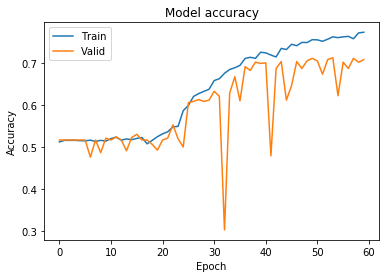

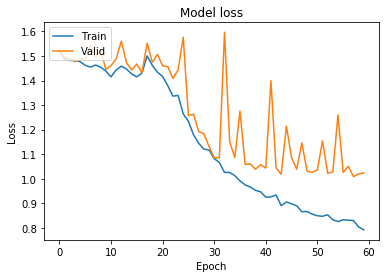

In [75]:
history_plot(history4)

In [32]:
model6 = load_model('models/CNN_model6_weights.hdf5')
model6.evaluate(x_valid_pad, y_valid_OH)

666/666 [==============================] - 33s 49ms/step


[1.0083805050577845, 0.7102102041244507]

In [33]:
y_pred6 = model6.predict(x_valid_pad)
y_pred6_indices = OH_to_label_indices(y_pred6)
y_pred6_label = indices_to_cat(y_pred6_indices)

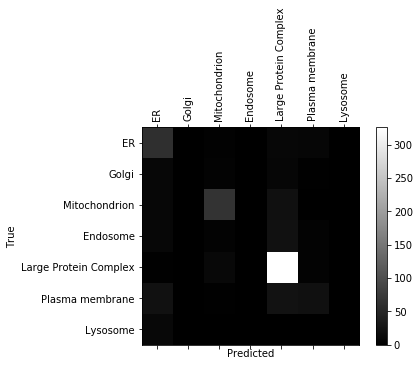

In [79]:
confusion_plot(y_valid, y_pred6_label, cat)

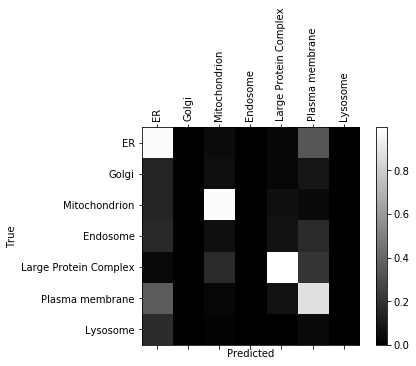

array([[ 61,   0,   3,   0,   9,   8,   0],
       [  9,   0,   4,   0,   8,   2,   0],
       [  9,   0,  65,   0,  21,   1,   0],
       [ 10,   0,   4,   0,  22,   4,   0],
       [  2,   0,  11,   0, 326,   5,   0],
       [ 22,   0,   2,   0,  23,  21,   0],
       [ 11,   0,   1,   0,   1,   1,   0]])

In [80]:
confusion_plot_norm(y_valid, y_pred6_label, cat, axis=1)

In [34]:
print(classification_report(y_valid, y_pred6_label))

                       precision    recall  f1-score   support

                   ER       0.49      0.75      0.60        81
             Endosome       0.00      0.00      0.00        40
                Golgi       0.00      0.00      0.00        23
Large Protein Complex       0.80      0.95      0.86       344
             Lysosome       0.00      0.00      0.00        14
        Mitochondrion       0.72      0.68      0.70        96
      Plasma membrane       0.50      0.31      0.38        68

             accuracy                           0.71       666
            macro avg       0.36      0.38      0.36       666
         weighted avg       0.63      0.71      0.66       666



In [81]:
print(classification_report(y_valid, y_pred6_label))

                       precision    recall  f1-score   support

                   ER       0.49      0.75      0.60        81
             Endosome       0.00      0.00      0.00        40
                Golgi       0.00      0.00      0.00        23
Large Protein Complex       0.80      0.95      0.86       344
             Lysosome       0.00      0.00      0.00        14
        Mitochondrion       0.72      0.68      0.70        96
      Plasma membrane       0.50      0.31      0.38        68

             accuracy                           0.71       666
            macro avg       0.36      0.38      0.36       666
         weighted avg       0.63      0.71      0.66       666



/home/julie/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model 7

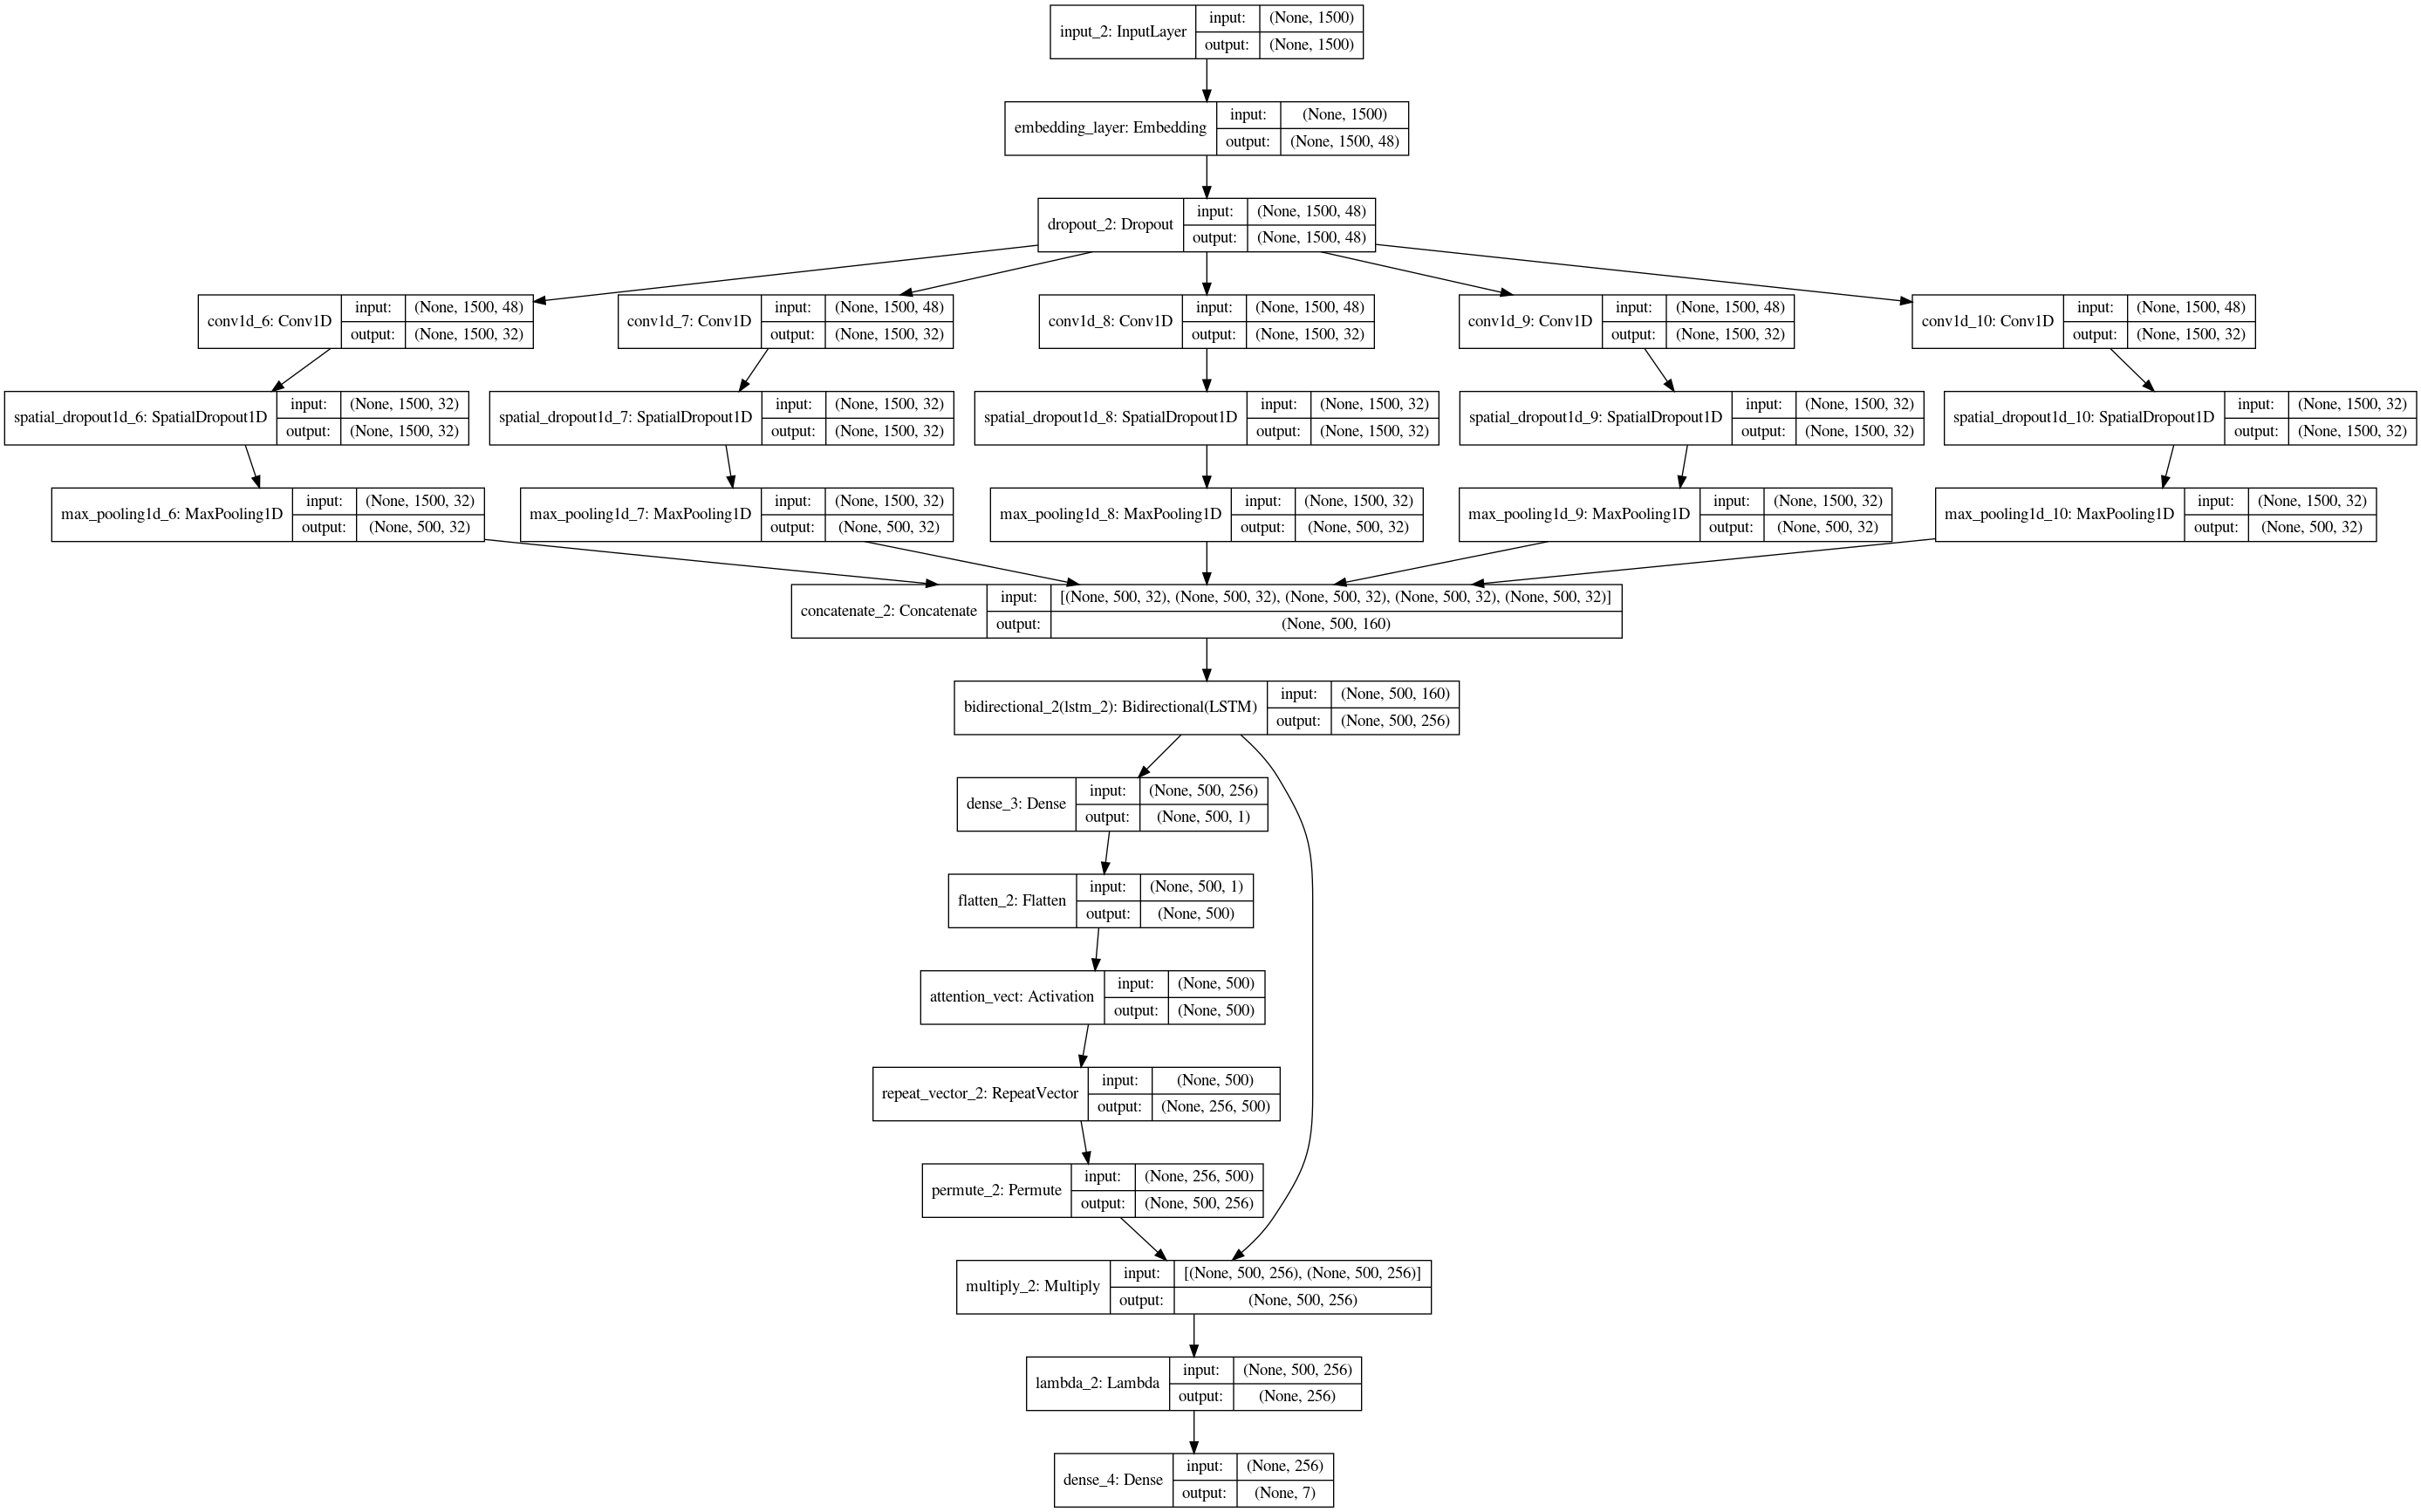

In [16]:
max_features = tot_aa
batch_size = 32

#LSTM
units = 128
# Embedding
embedding_size = 48
# Convolution
filters = 32
pool_size = 3

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(input_dim=max_features,output_dim=embedding_size,
        input_length=max_len, name = 'embedding_layer', trainable=True, mask_zero=False)(_input)

drop = Dropout(0.2)(embedded)
# Convolution layer of different size

conv2 = Conv1D(filters, 2, padding='same', activation='relu', 
              strides=1)(drop)
drop2 = SpatialDropout1D(0.2)(conv2)
pool2 = MaxPooling1D(pool_size=pool_size)(drop2)

conv3 = Conv1D(filters, 3, padding='same', activation='relu', 
              strides=1)(drop)
drop3 = SpatialDropout1D(0.2)(conv3)
pool3 = MaxPooling1D(pool_size=pool_size)(drop3)

conv5 = Conv1D(filters, 5, padding='same', activation='relu', 
              strides=1)(drop)
drop5 = SpatialDropout1D(0.2)(conv5)
pool5 = MaxPooling1D(pool_size=pool_size)(drop5)

conv9 = Conv1D(filters, 9, padding='same', activation='relu', 
              strides=1)(drop)
drop9 = SpatialDropout1D(0.2)(conv9)
pool9 = MaxPooling1D(pool_size=pool_size)(drop9)

conv12 = Conv1D(filters, 12, padding='same', activation='relu', 
              strides=1)(drop)
drop12 = SpatialDropout1D(0.2)(conv12)
pool12 = MaxPooling1D(pool_size=pool_size)(drop12)

#conv16 = Conv1D(filters, 16, padding='same', activation='relu', 
#              strides=1)(drop)
#drop16 = SpatialDropout1D(0.2)(conv16)
#pool16 = MaxPooling1D(pool_size=pool_size)(drop16)

# Concatenate the filters
#concat = concatenate([drop2, drop3, drop5, drop9, drop12], axis=2)
concat = concatenate([pool2, pool3, pool5, pool9, pool12], axis=2)

#pool = MaxPooling1D(pool_size=pool_size)(concat)

activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(concat)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(7, activation='softmax')(sent_representation)

model = Model(inputs=_input, outputs=probabilities)

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model = Model(inputs=_input, outputs=probabilities)
plot_model(model, to_file='models/CNN_model7_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models/CNN_model7_weights.hdf5', 
                           verbose=1, save_best_only=True)
# Train, train, train
history4 = model.fit(x_train_pad, y_train_OH, 
                    batch_size=32, epochs=60,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Instructions for updating:
Use tf.cast instead.
Train on 2660 samples, validate on 666 samples
Epoch 1/60
2660/2660 [==============================] - 176s 66ms/step - loss: 1.4812 - accuracy: 0.5128 - val_loss: 1.5639 - val_accuracy: 0.3949

Epoch 00001: val_loss improved from inf to 1.56391, saving model to models/CNN_model7_weights.hdf5
Epoch 2/60
2660/2660 [==============================] - 168s 63ms/step - loss: 1.3940 - accuracy: 0.5203 - val_loss: 1.4719 - val_accuracy: 0.4595

Epoch 00002: val_loss improved from 1.56391 to 1.47185, saving model to models/CNN_model7_weights.hdf5
Epoch 3/60
2660/2660 [==============================] - 170s 64ms/step - loss: 1.3368 - accuracy: 0.5353 - val_loss: 1.3772 - val_accuracy: 0.5450

Epoch 00003: val_loss improved from 1.47185 to 1.37715, saving model to models/CNN_model7_weights.hdf5
Epoch 4/60
2660/2660 [==============================] - 169s 64ms/step - loss: 1.2558 - accuracy: 0.5752 - val_loss: 1.3011 - val_accuracy: 0.5541

Epoch 00

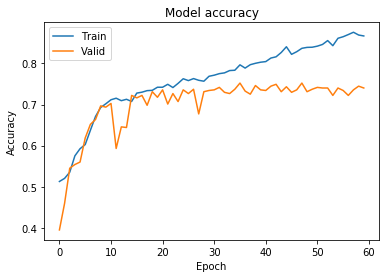

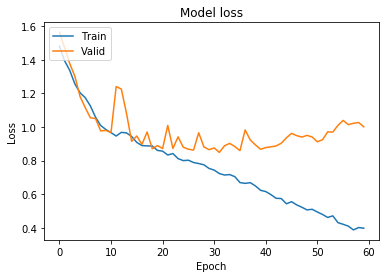

In [19]:
history_plot(history4)

In [20]:
model7 = load_model('models/CNN_model7_weights.hdf5')
model7.evaluate(x_valid_pad, y_valid_OH)

666/666 [==============================] - 11s 16ms/step


[0.8486220897497, 0.7417417168617249]

In [21]:
y_pred7 = model7.predict(x_valid_pad)
y_pred7_indices = OH_to_label_indices(y_pred7)
y_pred7_label = indices_to_cat(y_pred7_indices)

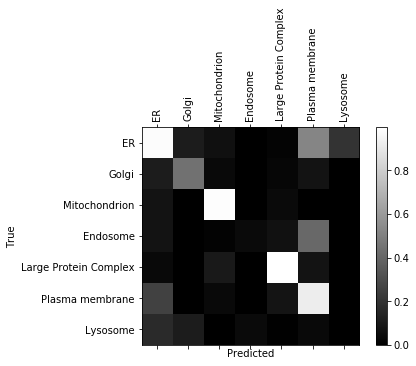

array([[ 53,   1,   5,   0,   6,  14,   2],
       [  6,   4,   3,   0,   8,   2,   0],
       [  4,   0,  79,   0,  13,   0,   0],
       [  4,   0,   1,   1,  23,  11,   0],
       [  2,   0,   8,   0, 332,   2,   0],
       [ 14,   0,   3,   0,  26,  25,   0],
       [  9,   1,   0,   1,   2,   1,   0]])

In [25]:
confusion_plot_norm(y_valid, y_pred7_label, cat, axis=1)

In [26]:
print(classification_report(y_valid, y_pred7_label))

                       precision    recall  f1-score   support

                   ER       0.58      0.65      0.61        81
             Endosome       0.50      0.03      0.05        40
                Golgi       0.67      0.17      0.28        23
Large Protein Complex       0.81      0.97      0.88       344
             Lysosome       0.00      0.00      0.00        14
        Mitochondrion       0.80      0.82      0.81        96
      Plasma membrane       0.45      0.37      0.41        68

             accuracy                           0.74       666
            macro avg       0.54      0.43      0.43       666
         weighted avg       0.70      0.74      0.70       666



# Model 8

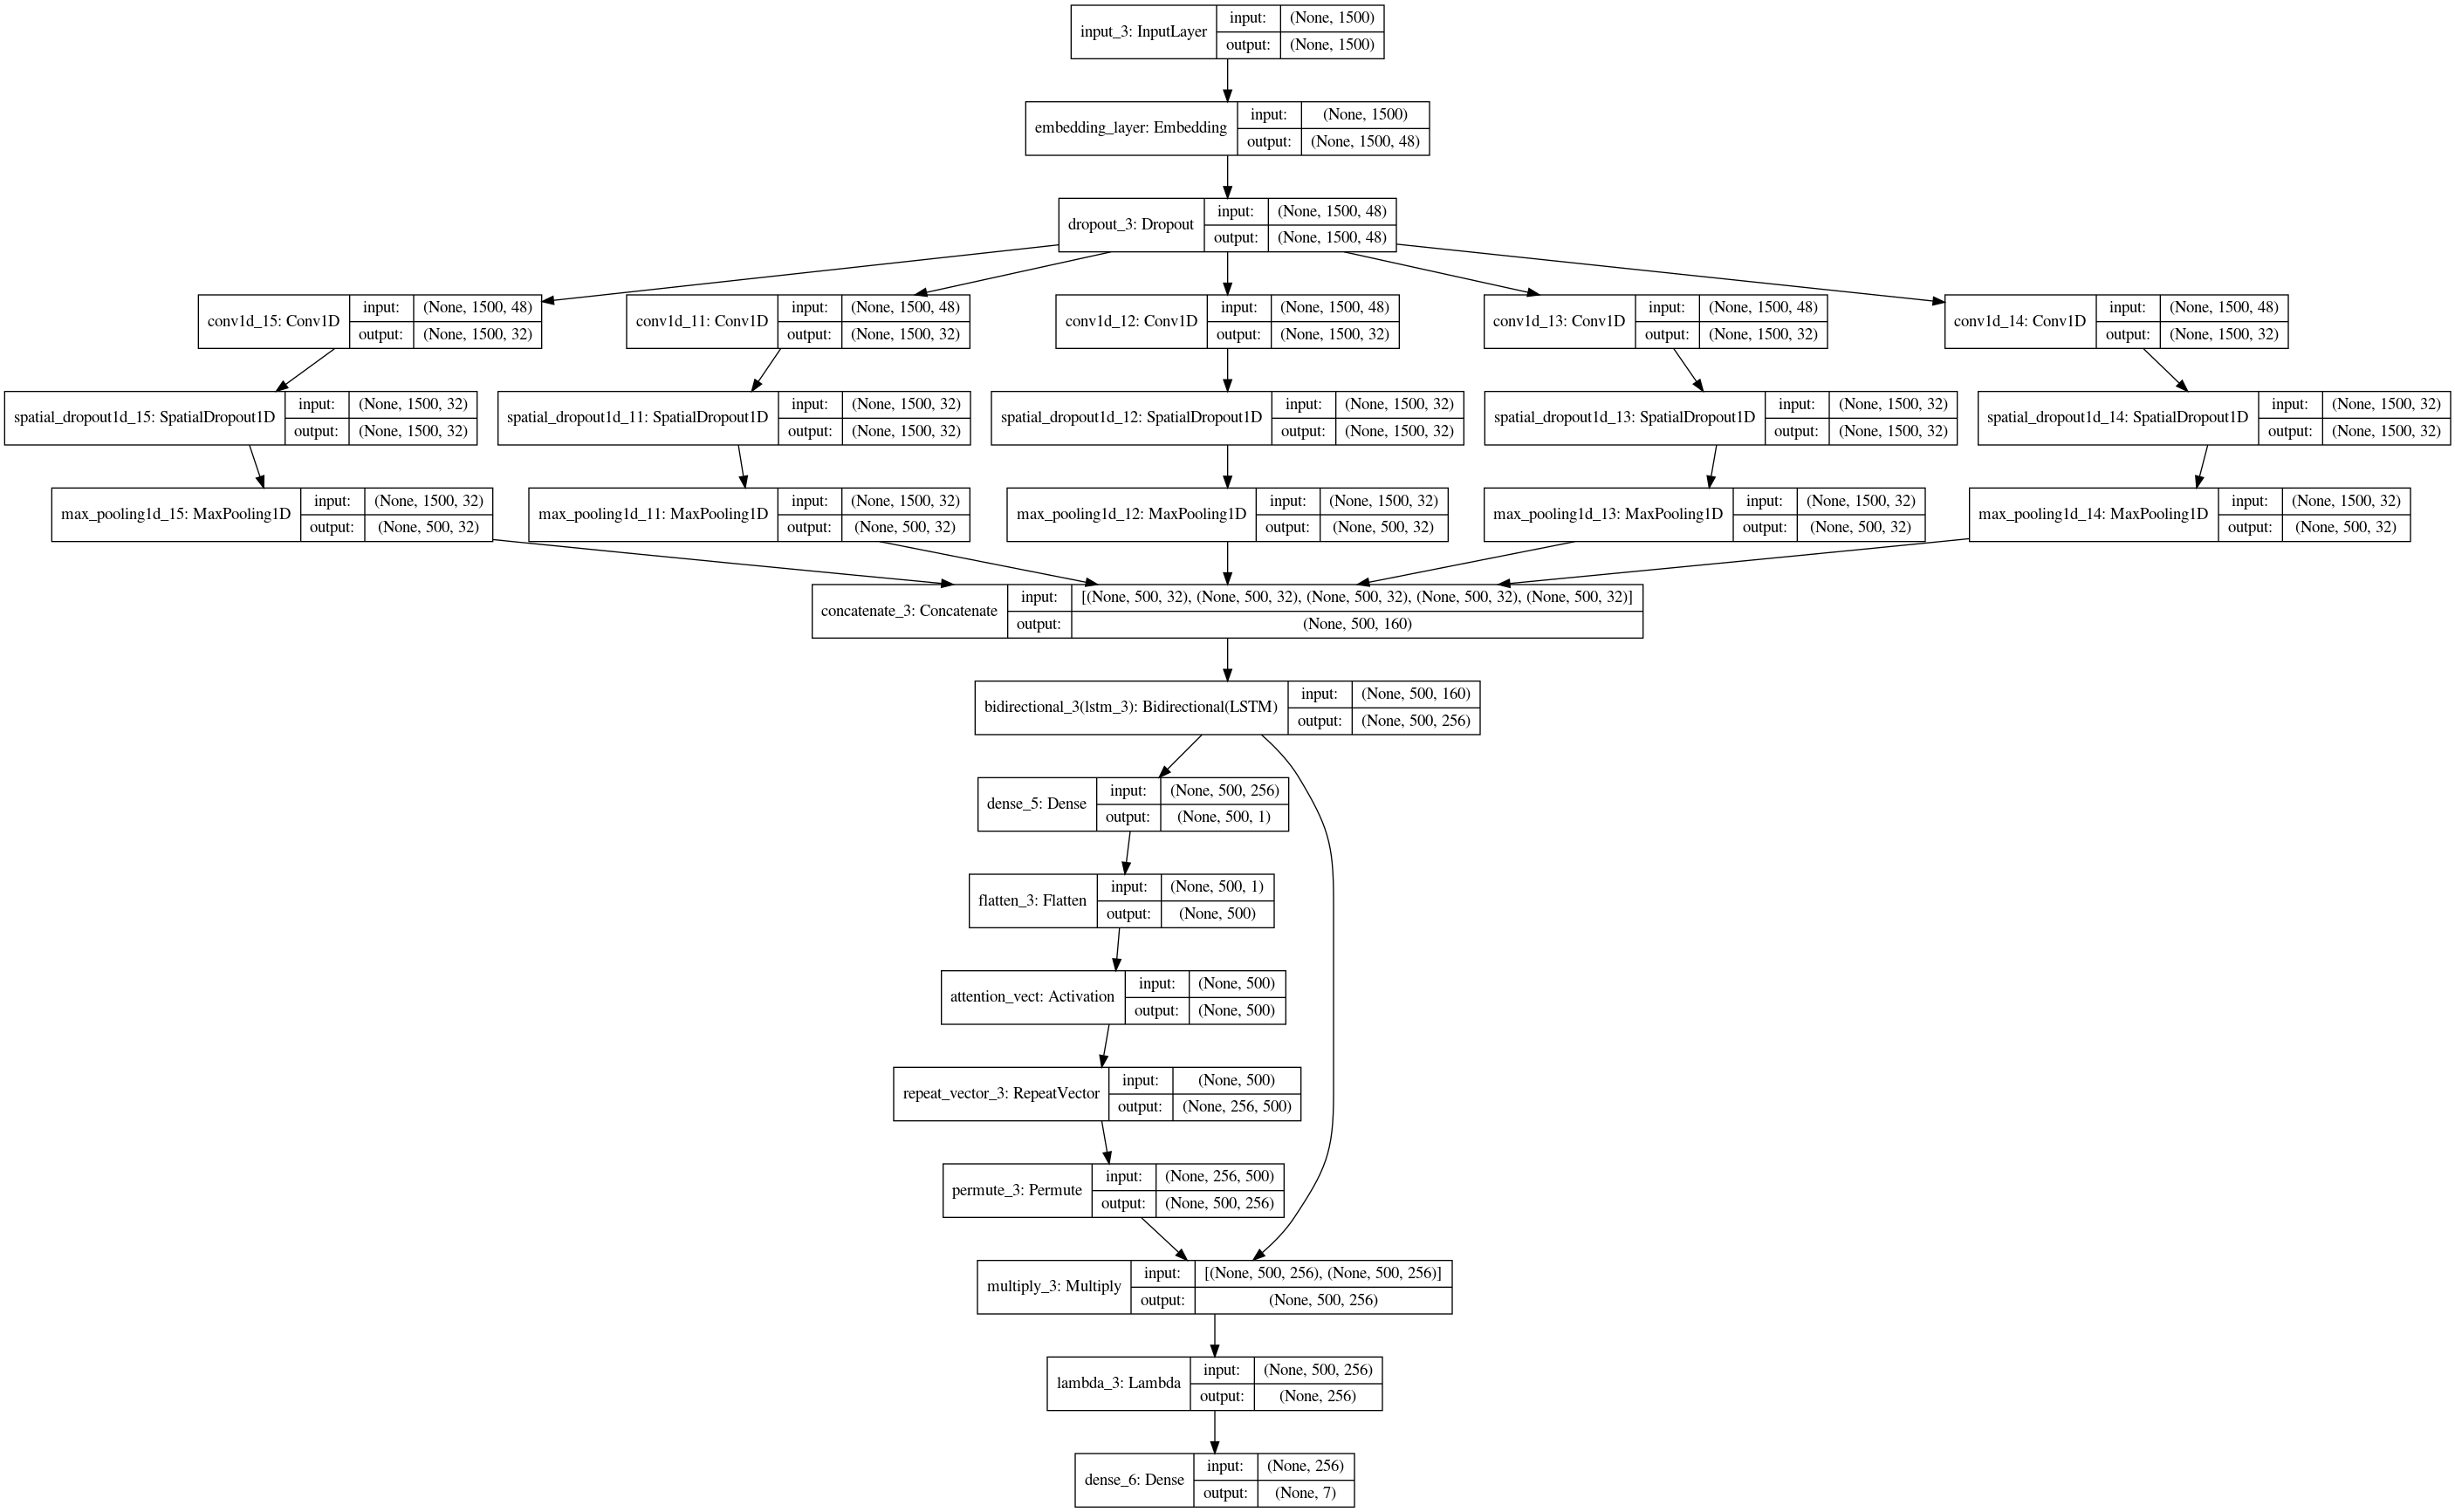

In [27]:
max_features = tot_aa
batch_size = 32

#LSTM
units = 128
# Embedding
embedding_size = 48
# Convolution
filters = 32
pool_size = 3

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(input_dim=max_features,output_dim=embedding_size,
        input_length=max_len, name = 'embedding_layer', trainable=True, mask_zero=False)(_input)

drop = Dropout(0.2)(embedded)
# Convolution layer of different size

#conv2 = Conv1D(filters, 2, padding='same', activation='relu', 
#              strides=1)(drop)
#drop2 = SpatialDropout1D(0.2)(conv2)
#pool2 = MaxPooling1D(pool_size=pool_size)(drop2)

conv3 = Conv1D(filters, 3, padding='same', activation='relu', 
              strides=1)(drop)
drop3 = SpatialDropout1D(0.2)(conv3)
pool3 = MaxPooling1D(pool_size=pool_size)(drop3)

conv5 = Conv1D(filters, 5, padding='same', activation='relu', 
              strides=1)(drop)
drop5 = SpatialDropout1D(0.2)(conv5)
pool5 = MaxPooling1D(pool_size=pool_size)(drop5)

conv9 = Conv1D(filters, 9, padding='same', activation='relu', 
              strides=1)(drop)
drop9 = SpatialDropout1D(0.2)(conv9)
pool9 = MaxPooling1D(pool_size=pool_size)(drop9)

conv12 = Conv1D(filters, 12, padding='same', activation='relu', 
              strides=1)(drop)
drop12 = SpatialDropout1D(0.2)(conv12)
pool12 = MaxPooling1D(pool_size=pool_size)(drop12)

conv16 = Conv1D(filters, 16, padding='same', activation='relu', 
              strides=1)(drop)
drop16 = SpatialDropout1D(0.2)(conv16)
pool16 = MaxPooling1D(pool_size=pool_size)(drop16)

# Concatenate the filters
#concat = concatenate([drop2, drop3, drop5, drop9, drop12], axis=2)
concat = concatenate([pool16, pool3, pool5, pool9, pool12], axis=2)

#pool = MaxPooling1D(pool_size=pool_size)(concat)

activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(concat)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(7, activation='softmax')(sent_representation)

model = Model(inputs=_input, outputs=probabilities)

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model = Model(inputs=_input, outputs=probabilities)
plot_model(model, to_file='models/CNN_model8_plot.png', show_shapes=True, show_layer_names=True)

In [28]:
model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models/CNN_model8_weights.hdf5', 
                           verbose=1, save_best_only=True)
# Train, train, train
history4 = model.fit(x_train_pad, y_train_OH, 
                    batch_size=32, epochs=60,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Train on 2660 samples, validate on 666 samples
Epoch 1/60
2660/2660 [==============================] - 180s 68ms/step - loss: 1.4720 - accuracy: 0.5124 - val_loss: 1.4234 - val_accuracy: 0.5285

Epoch 00001: val_loss improved from inf to 1.42342, saving model to models/CNN_model8_weights.hdf5
Epoch 2/60
2660/2660 [==============================] - 191s 72ms/step - loss: 1.3592 - accuracy: 0.5323 - val_loss: 1.3329 - val_accuracy: 0.5556

Epoch 00002: val_loss improved from 1.42342 to 1.33294, saving model to models/CNN_model8_weights.hdf5
Epoch 3/60
2660/2660 [==============================] - 178s 67ms/step - loss: 1.2667 - accuracy: 0.5756 - val_loss: 1.4848 - val_accuracy: 0.5360

Epoch 00003: val_loss did not improve from 1.33294
Epoch 4/60
2660/2660 [==============================] - 176s 66ms/step - loss: 1.1712 - accuracy: 0.6135 - val_loss: 1.0998 - val_accuracy: 0.6727

Epoch 00004: val_loss improved from 1.33294 to 1.09985, saving model to models/CNN_model8_weights.hdf5
Epoch


Epoch 00038: val_loss did not improve from 0.85929
Epoch 39/60
2660/2660 [==============================] - 174s 66ms/step - loss: 0.5617 - accuracy: 0.8267 - val_loss: 0.9503 - val_accuracy: 0.7297

Epoch 00039: val_loss did not improve from 0.85929
Epoch 40/60
2660/2660 [==============================] - 174s 65ms/step - loss: 0.5400 - accuracy: 0.8335 - val_loss: 0.9042 - val_accuracy: 0.7477

Epoch 00040: val_loss did not improve from 0.85929
Epoch 41/60
2660/2660 [==============================] - 174s 65ms/step - loss: 0.5564 - accuracy: 0.8282 - val_loss: 0.9302 - val_accuracy: 0.7462

Epoch 00041: val_loss did not improve from 0.85929
Epoch 42/60
2660/2660 [==============================] - 173s 65ms/step - loss: 0.5316 - accuracy: 0.8346 - val_loss: 0.9894 - val_accuracy: 0.7402

Epoch 00042: val_loss did not improve from 0.85929
Epoch 43/60
2660/2660 [==============================] - 175s 66ms/step - loss: 0.5075 - accuracy: 0.8376 - val_loss: 0.9765 - val_accuracy: 0.7462


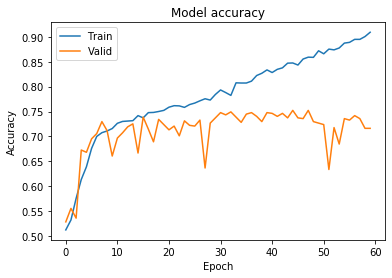

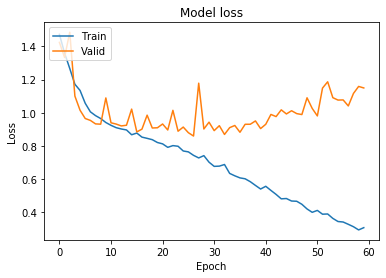

In [29]:
history_plot(history4)

In [30]:
model8 = load_model('models/CNN_model8_weights.hdf5')
model8.evaluate(x_valid_pad, y_valid_OH)

666/666 [==============================] - 15s 23ms/step


[0.8592878154090217, 0.7327327132225037]

In [31]:
y_pred8 = model8.predict(x_valid_pad)
y_pred8_indices = OH_to_label_indices(y_pred8)
y_pred8_label = indices_to_cat(y_pred8_indices)

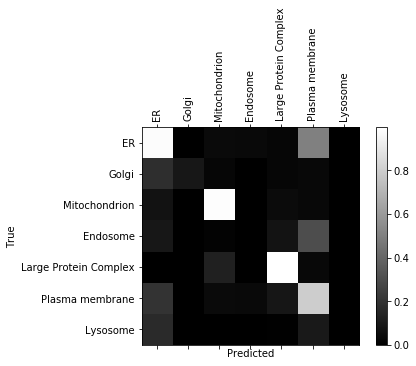

array([[ 54,   0,   3,   1,   8,  15,   0],
       [ 10,   1,   2,   0,   9,   1,   0],
       [  4,   0,  76,   0,  15,   1,   0],
       [  5,   0,   1,   0,  25,   9,   0],
       [  0,   0,  10,   0, 333,   1,   0],
       [ 11,   0,   3,   1,  29,  24,   0],
       [  9,   0,   0,   0,   2,   3,   0]])

In [32]:
confusion_plot_norm(y_valid, y_pred8_label, cat, axis=1)

In [33]:
print(classification_report(y_valid, y_pred8_label))

                       precision    recall  f1-score   support

                   ER       0.58      0.67      0.62        81
             Endosome       0.00      0.00      0.00        40
                Golgi       1.00      0.04      0.08        23
Large Protein Complex       0.79      0.97      0.87       344
             Lysosome       0.00      0.00      0.00        14
        Mitochondrion       0.80      0.79      0.80        96
      Plasma membrane       0.44      0.35      0.39        68

             accuracy                           0.73       666
            macro avg       0.52      0.40      0.39       666
         weighted avg       0.67      0.73      0.68       666



/home/julie/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model 9

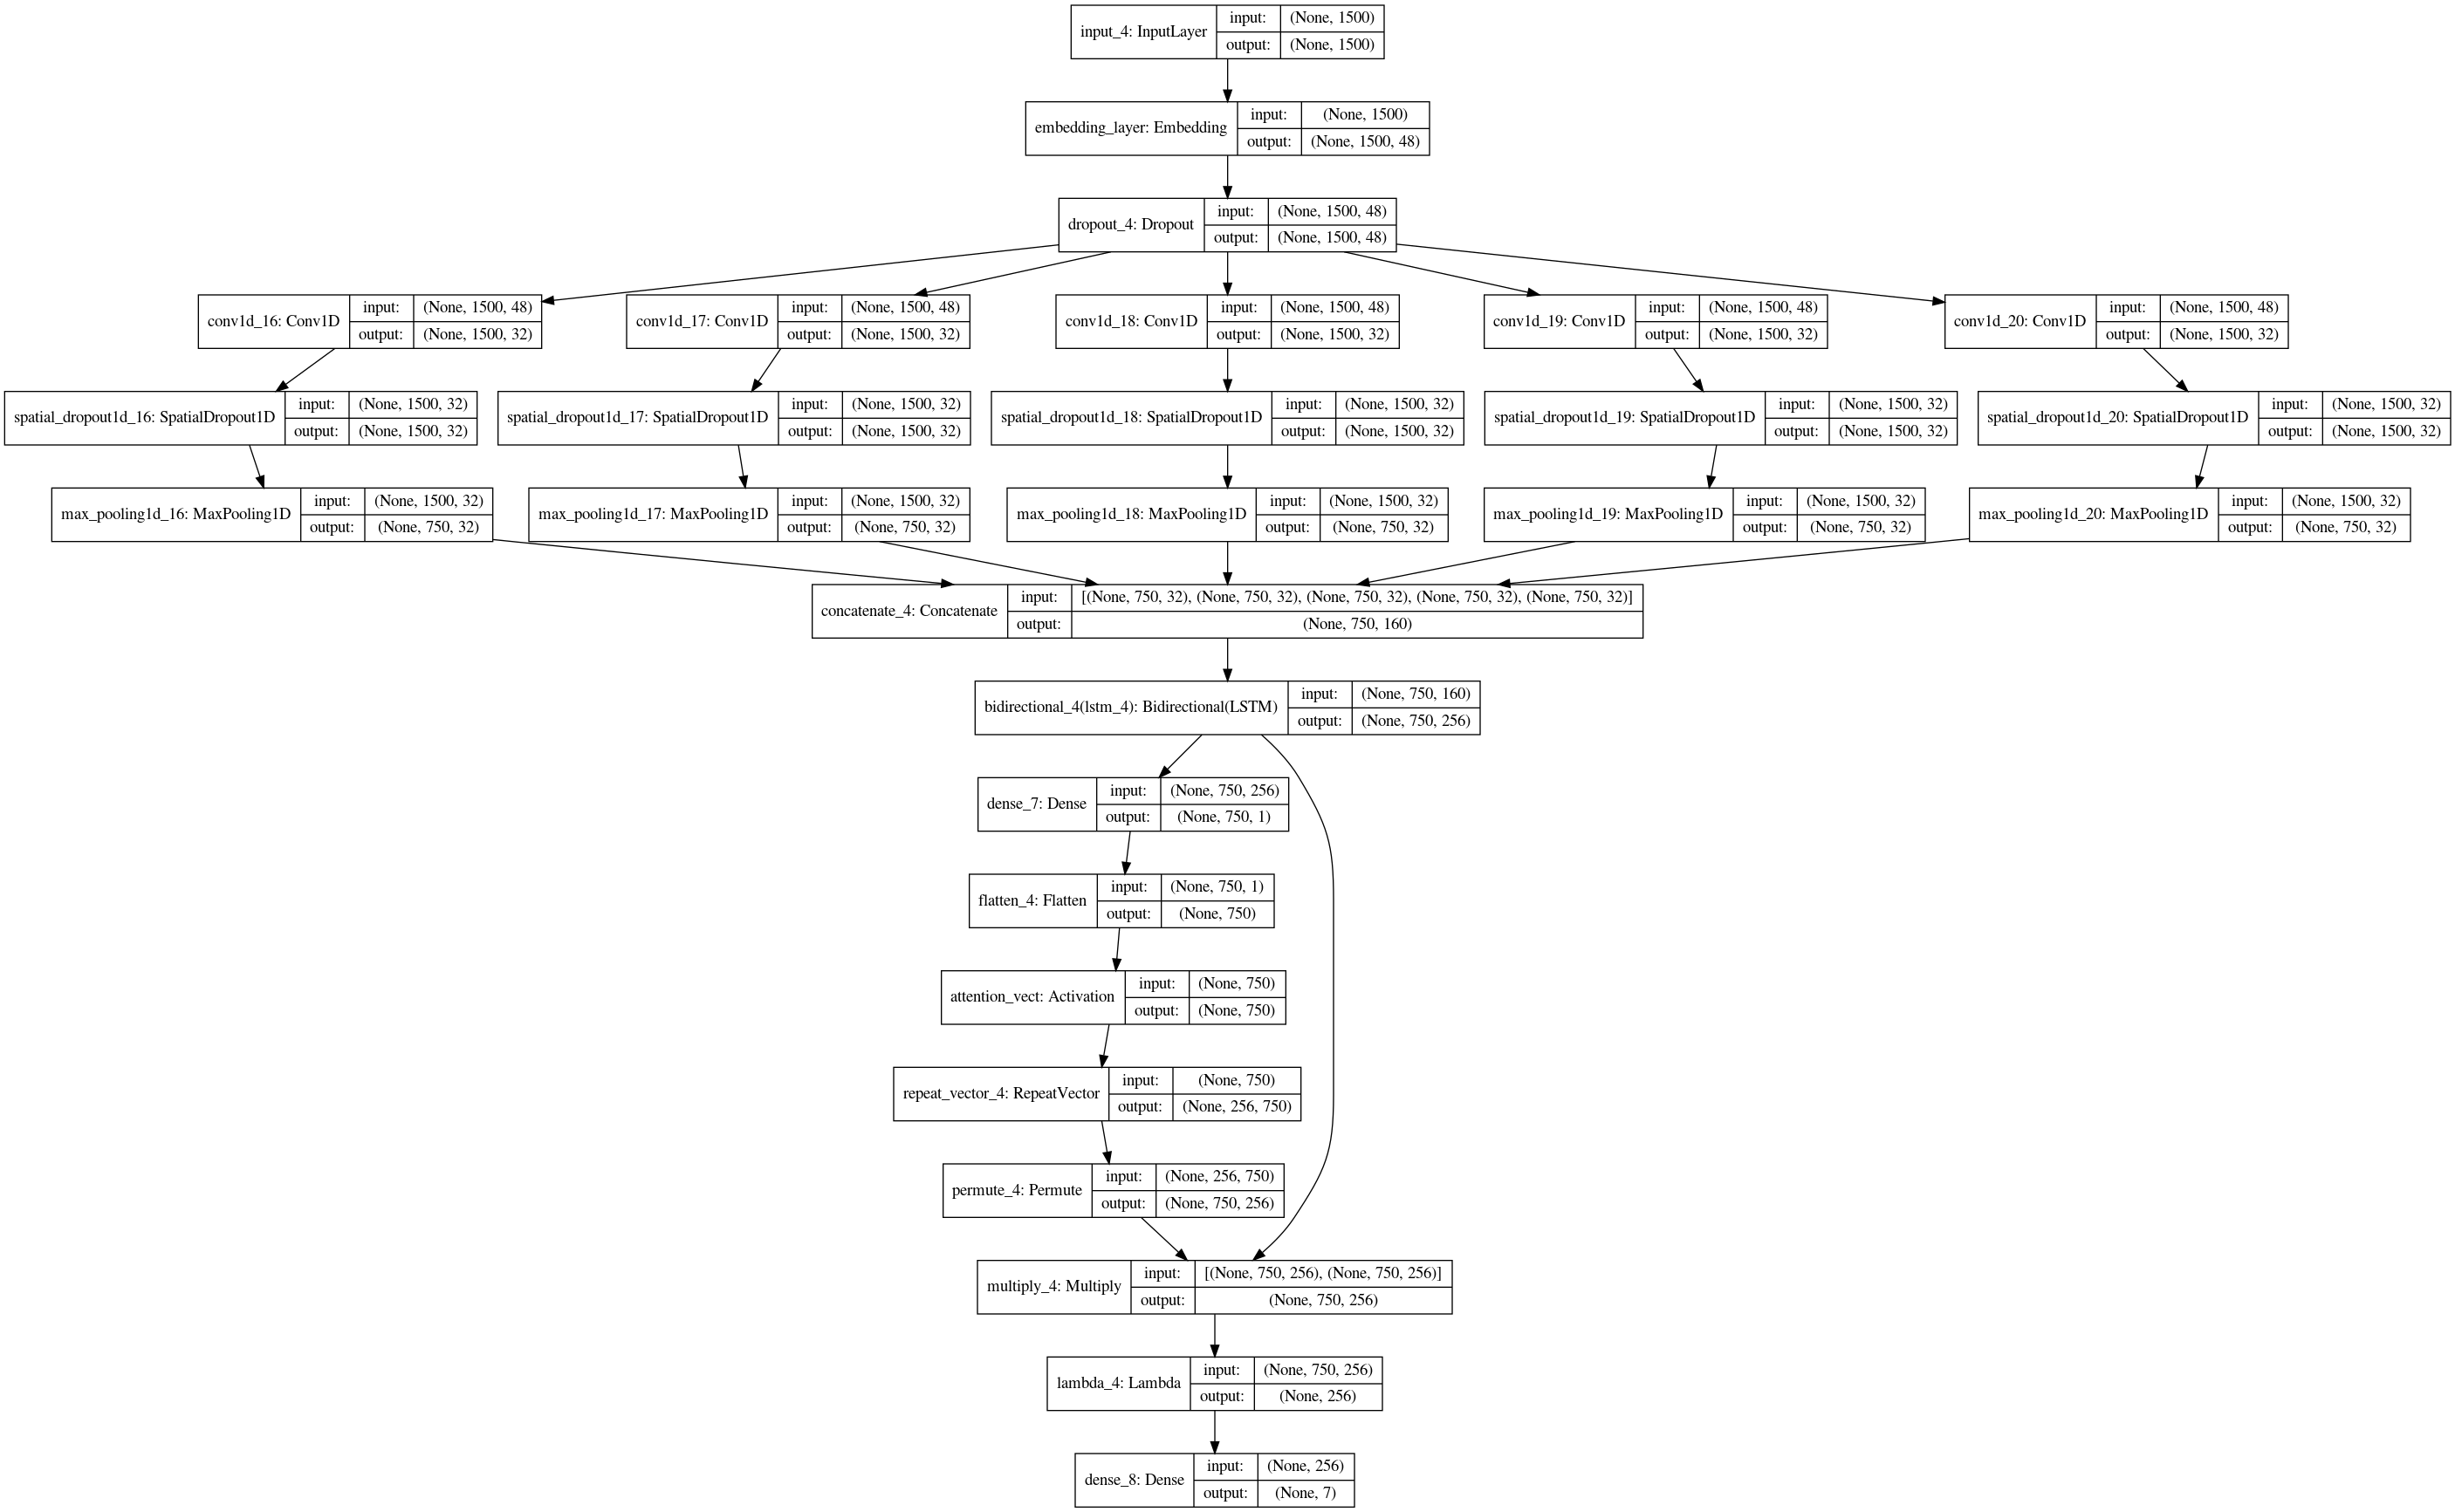

In [34]:
max_features = tot_aa
batch_size = 32

#LSTM
units = 128
# Embedding
embedding_size = 48
# Convolution
filters = 32
pool_size = 2

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(input_dim=max_features,output_dim=embedding_size,
        input_length=max_len, name = 'embedding_layer', trainable=True, mask_zero=False)(_input)

drop = Dropout(0.2)(embedded)
# Convolution layer of different size

conv2 = Conv1D(filters, 2, padding='same', activation='relu', 
              strides=1)(drop)
drop2 = SpatialDropout1D(0.2)(conv2)
pool2 = MaxPooling1D(pool_size=pool_size)(drop2)

conv4 = Conv1D(filters, 4, padding='same', activation='relu', 
              strides=1)(drop)
drop4 = SpatialDropout1D(0.2)(conv4)
pool4 = MaxPooling1D(pool_size=pool_size)(drop4)

conv6 = Conv1D(filters, 6, padding='same', activation='relu', 
              strides=1)(drop)
drop6 = SpatialDropout1D(0.2)(conv6)
pool6 = MaxPooling1D(pool_size=pool_size)(drop6)

conv8 = Conv1D(filters, 8, padding='same', activation='relu', 
              strides=1)(drop)
drop8 = SpatialDropout1D(0.2)(conv8)
pool8 = MaxPooling1D(pool_size=pool_size)(drop8)

conv10 = Conv1D(filters, 10, padding='same', activation='relu', 
              strides=1)(drop)
drop10 = SpatialDropout1D(0.2)(conv10)
pool10 = MaxPooling1D(pool_size=pool_size)(drop10)

# Concatenate the filters
concat = concatenate([pool2, pool4, pool6, pool8, pool10], axis=2)

#pool = MaxPooling1D(pool_size=pool_size)(concat)

activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(concat)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(7, activation='softmax')(sent_representation)

model = Model(inputs=_input, outputs=probabilities)

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model = Model(inputs=_input, outputs=probabilities)
plot_model(model, to_file='models/CNN_model9_plot.png', show_shapes=True, show_layer_names=True)

In [35]:
model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models/CNN_model9_weights.hdf5', 
                           verbose=1, save_best_only=True)
# Train, train, train
history9 = model.fit(x_train_pad, y_train_OH, 
                    batch_size=32, epochs=40,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Train on 2660 samples, validate on 666 samples
Epoch 1/40
2660/2660 [==============================] - 266s 100ms/step - loss: 1.4812 - accuracy: 0.5098 - val_loss: 1.4322 - val_accuracy: 0.5165

Epoch 00001: val_loss improved from inf to 1.43219, saving model to models/CNN_model9_weights.hdf5
Epoch 2/40
2660/2660 [==============================] - 217s 81ms/step - loss: 1.3759 - accuracy: 0.5263 - val_loss: 1.3496 - val_accuracy: 0.5390

Epoch 00002: val_loss improved from 1.43219 to 1.34963, saving model to models/CNN_model9_weights.hdf5
Epoch 3/40
2660/2660 [==============================] - 215s 81ms/step - loss: 1.2974 - accuracy: 0.5602 - val_loss: 1.2878 - val_accuracy: 0.5586

Epoch 00003: val_loss improved from 1.34963 to 1.28781, saving model to models/CNN_model9_weights.hdf5
Epoch 4/40
2660/2660 [==============================] - 212s 80ms/step - loss: 1.2549 - accuracy: 0.5767 - val_loss: 1.2351 - val_accuracy: 0.5841

Epoch 00004: val_loss improved from 1.28781 to 1.23510,

2660/2660 [==============================] - 212s 80ms/step - loss: 0.7805 - accuracy: 0.7654 - val_loss: 0.9207 - val_accuracy: 0.7222

Epoch 00038: val_loss did not improve from 0.88045
Epoch 39/40
2660/2660 [==============================] - 215s 81ms/step - loss: 0.7398 - accuracy: 0.7767 - val_loss: 0.9296 - val_accuracy: 0.7207

Epoch 00039: val_loss did not improve from 0.88045
Epoch 40/40
2660/2660 [==============================] - 212s 80ms/step - loss: 0.7382 - accuracy: 0.7774 - val_loss: 0.8929 - val_accuracy: 0.7297

Epoch 00040: val_loss did not improve from 0.88045


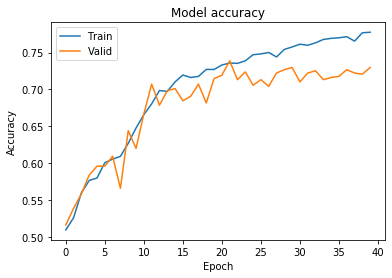

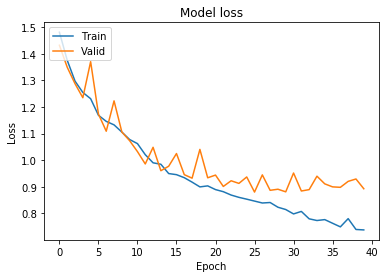

In [40]:
history_plot(history9)

In [36]:
model9 = load_model('models/CNN_model9_weights.hdf5')
model9.evaluate(x_valid_pad, y_valid_OH)

666/666 [==============================] - 17s 26ms/step


[0.8804507774633689, 0.7132132053375244]

In [37]:
y_pred9 = model9.predict(x_valid_pad)
y_pred9_indices = OH_to_label_indices(y_pred9)
y_pred9_label = indices_to_cat(y_pred9_indices)

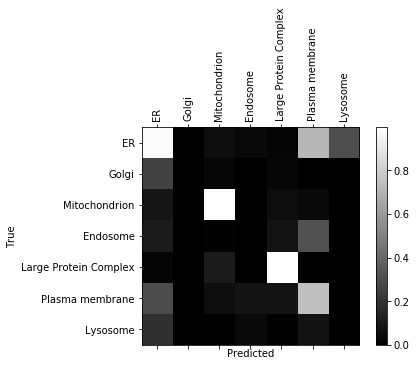

array([[ 46,   0,   4,   1,   7,  20,   3],
       [ 12,   0,   2,   0,   9,   0,   0],
       [  4,   0,  73,   0,  18,   1,   0],
       [  5,   0,   1,   0,  25,   9,   0],
       [  1,   0,   8,   0, 335,   0,   0],
       [ 14,   0,   4,   2,  27,  21,   0],
       [  9,   0,   0,   1,   2,   2,   0]])

In [38]:
confusion_plot_norm(y_valid, y_pred9_label, cat, axis=1)

In [39]:
print(classification_report(y_valid, y_pred9_label))

                       precision    recall  f1-score   support

                   ER       0.51      0.57      0.53        81
             Endosome       0.00      0.00      0.00        40
                Golgi       0.00      0.00      0.00        23
Large Protein Complex       0.79      0.97      0.87       344
             Lysosome       0.00      0.00      0.00        14
        Mitochondrion       0.79      0.76      0.78        96
      Plasma membrane       0.40      0.31      0.35        68

             accuracy                           0.71       666
            macro avg       0.36      0.37      0.36       666
         weighted avg       0.63      0.71      0.66       666



/home/julie/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Embedding Analysis

In [77]:
embedding = model.get_layer('embedding_layer').get_weights()
embedding = embedding[0]
embedding.shape

(22, 40)

In [78]:
embedding2 = model2.get_layer('embedding_layer').get_weights()
embedding2 = embedding2[0]
embedding2.shape

(22, 40)

In [82]:
embedding6 = model6.get_layer('embedding_layer').get_weights()
embedding6 = embedding6[0]
embedding6.shape

(22, 48)

In [84]:
def plot_embedding(embedding, aa):
    fig, ax = plt.subplots()
    plt.scatter(embedding[:, 0], embedding[:, 1], edgecolor='none')
    aaL = list(aa)
    for i in range(len(aaL)):
        ax.annotate(aaL[i], (embedding[:, 0][i], embedding[:, 1][i]))
    
    plt.show()

### PCA plot

original shape:    (22, 48)
transformed shape: (22, 2)


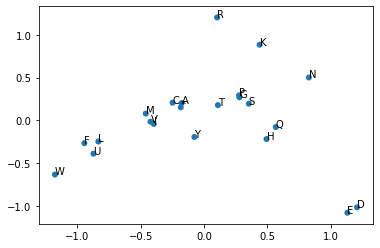

In [31]:
# PCA plots of Embedding 
pca = PCA(n_components=2)
pca.fit(embedding)
embedding_pca = pca.transform(embedding)
print("original shape:   ", embedding.shape)
print("transformed shape:", embedding_pca.shape)
plot_embedding(embedding_pca, aa)

### t-SNE plot

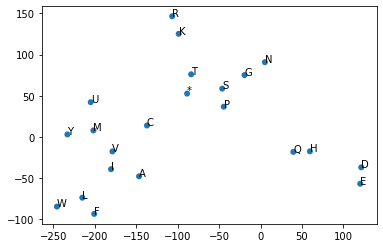

In [32]:
# tSNE plots of Embedding 
tSNE = TSNE(n_components=2, perplexity=3)
embedding_tSNE = tSNE.fit_transform(embedding)
plot_embedding(embedding_tSNE, aa)

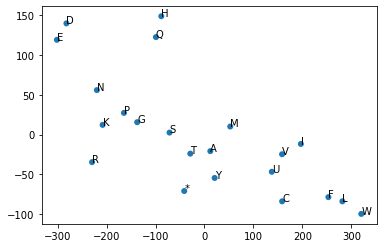

In [80]:
tSNE = TSNE(n_components=2, perplexity=3)
embedding2_tSNE = tSNE.fit_transform(embedding2)
plot_embedding(embedding2_tSNE, aa)

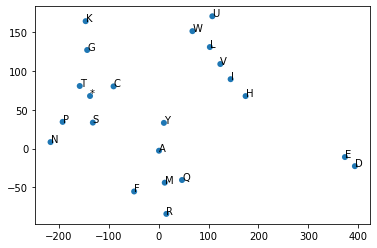

In [86]:
tSNE = TSNE(n_components=2, perplexity=2)
embedding6_tSNE = tSNE.fit_transform(embedding6)
plot_embedding(embedding6_tSNE, aa)

### UMAP plot

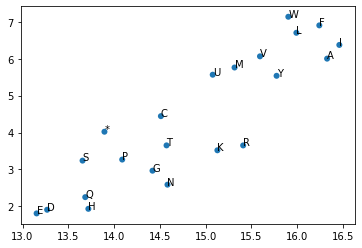

In [36]:
# umap plots of Embedding 
Umap = umap.UMAP(n_components=2, n_neighbors= 4)
embedding_Umap = Umap.fit_transform(embedding)
plot_embedding(embedding_Umap, aa)

## Attention Layer Analysis

In [37]:
model = Model(inputs=model.input,
              outputs=[model.output, model.get_layer('attention_vect').output])
outputs = model.predict(x_valid_pad)
model_outputs = outputs[0]
attention_outputs = outputs[1]

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


Text(0, 0.5, 'Attention Distribution')

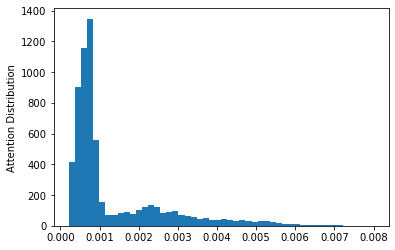

In [38]:
attention_distrib = np.concatenate( attention_outputs, axis=0 )
plt.hist(attention_distrib, normed=True, bins=50)
plt.ylabel('Attention Distribution')

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


Text(0, 0.5, 'Attention Distribution')

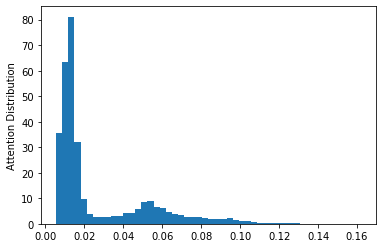

In [39]:
# Normalize attention values 
norm_attention = []
for seq in attention_outputs:
    norm_attention.append(seq / np.linalg.norm(seq))
    
attention_distrib = np.concatenate( norm_attention, axis=0 )
plt.hist(attention_distrib, normed=True, bins=50)
plt.ylabel('Attention Distribution')

### Model 3 Attention distribution

In [41]:
model = load_model('models/CNN_model7_weights.hdf5')
model = Model(inputs=model.input,
              outputs=[model.output, model.get_layer('attention_vect').output])
outputs = model.predict(x_valid_pad)
model_outputs = outputs[0]
attention_outputs = outputs[1]

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


Text(0, 0.5, 'Attention Distribution')

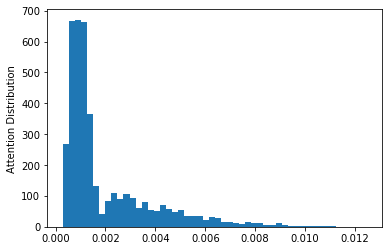

In [42]:
attention_distrib = np.concatenate( attention_outputs, axis=0 )
plt.hist(attention_distrib, normed=True, bins=50)
plt.ylabel('Attention Distribution')

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


Text(0, 0.5, 'Attention Distribution')

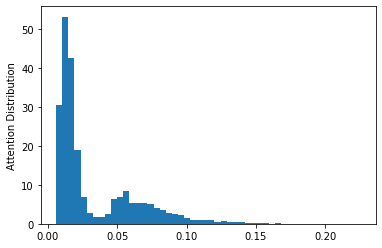

In [43]:
# Normalize attention values 
norm_attention = []
for seq in attention_outputs:
    norm_attention.append(seq / np.linalg.norm(seq))
    
attention_distrib = np.concatenate( norm_attention, axis=0 )
plt.hist(attention_distrib, normed=True, bins=50)
plt.ylabel('Attention Distribution')

### Attention visualization for a single sequence

Because I pooled (pool size = 2) attention is len = 750. 
So I need to duplicate every values.

In [112]:
def indices_to_seq(X):
    seq = ''
    for i in range(len(X)):
        seq +=int_to_aa[X[i]] 
    return seq

In [113]:
# pool_size = 2
Attention_1500 = []
A = []
for x in norm_attention:
    for i in range(len(x)):
        A.append(x[i])
        A.append(x[i])
    Attention_1500.append(np.array(A))
    A = []

In [114]:
# I don't fully understand that code
# the color_charvals function doesn't work that well because my vector is big
# and the values are very small, I need a better function

class CharVal(object):
    def __init__(self, char, val):
        self.char = char
        self.val = val

    def __str__(self):
        return self.char

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def color_charvals(s):
    r = 0
    if s.val < 0.07:
        r = 255
    elif s.val > 0.1:
        r = 0
    else:
        r = 255*(1 - (s.val-0.07)/0.03)
    r = int(r)
    color = rgb_to_hex((255, r, 255))
    return 'background-color: %s' % color
    
    #r = int(255/(s.val*10 +1))
    #color = rgb_to_hex((r, r, r))
    #return 'background-color: %s' % color

In [115]:
# Number of highest values to select
nb_max = 30
max_att_indexes = []
for seq in Attention_1500:
    max_att_indexes.append(np.sort(np.argpartition(seq, -nb_max)[-nb_max:]))
max_att_nopad = []    
for x in range(len(x_valid)):
    max_att_nopad.append(max_att_indexes[x]-(1500-len(x_valid[x])))

In [116]:
X = 3

def color_charvals(s):
    r = 255-int(s.val*255)
    color = rgb_to_hex((255,255 , r))
    return 'background-color: %s' % color

max_ind = max_att_nopad[X]
max_vect = np.zeros(len(x_valid[X]))
for val in max_ind:
    max_vect[val] = 1
# match each aa and attention
char_vals = [CharVal(c, v) for c, v in 
             zip(x_valid[X], max_vect)]

char_df = pd.DataFrame(char_vals).transpose()
# apply coloring values
char_df = char_df.style.applymap(color_charvals)
char_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236
0,M,L,E,E,D,M,E,V,A,I,K,M,V,V,V,G,N,G,A,V,G,K,S,S,M,I,Q,R,Y,C,K,G,I,F,T,K,D,Y,K,K,T,I,G,V,D,F,L,E,R,Q,I,Q,V,N,D,E,D,V,R,L,M,L,W,D,T,A,G,Q,E,E,F,D,A,I,T,K,A,Y,Y,R,G,A,Q,A,C,V,L,V,F,S,T,T,D,R,E,S,F,E,A,V,S,S,W,R,E,K,V,V,A,E,V,G,D,I,P,T,V,L,V,Q,N,K,I,D,L,L,D,D,S,C,I,K,N,E,E,A,E,A,L,A,K,R,L,K,L,R,F,Y,R,T,S,V,K,E,D,L,N,V,N,E,V,F,K,Y,L,A,E,K,Y,L,Q,K,L,K,Q,Q,I,A,E,D,P,E,L,T,H,S,S,S,N,K,I,G,V,F,N,T,S,G,G,S,H,S,G,Q,N,S,G,T,L,N,G,G,D,V,I,N,L,R,P,N,K,Q,R,T,K,K,N,R,N,P,F,S,S,C,S,I,P


## Error Analysis

In [117]:
# Add the prediction to Valid dataframe
valid["Model Prediction"] = y_pred_label

In [118]:
valid.groupby(["Compartment Prediction", "Model Prediction"]).count()#/len(valid)*100

Lead Protein ID  \
Compartment Prediction Model Prediction                         
ER                     ER                                  52   
                       Large Protein Complex                2   
                       Mitochondrion                        3   
                       Plasma membrane                     15   
Endosome               ER                                   3   
                       Large Protein Complex               17   
                       Plasma membrane                     11   
Golgi                  ER                                   8   
                       Golgi                                3   
                       Large Protein Complex                4   
                       Mitochondrion                        2   
Large Protein Complex  ER                                   5   
                       Large Protein Complex              295   
                       Mitochondrion                        2   
                       Plasma membrane                      6   
Lysosome               ER                                   4   
                       Golgi                                1   
                       Lysosome                             2   
                       Plasma membrane                      5   
Mitochondrion          ER                                   3   
                       Golgi                                1   
                       Large Protein Complex               15   
                       Mitochondrion                       64   
                       Plasma membrane                      5   
Plasma membrane        ER                                   5   
                       Large Protein Complex               23   
                       Plasma membrane                     31   

                                              Prediction Confidence  Sequence  \
Compartment Prediction Model Prediction                                         
ER                     ER                                        52        52   
                       Large Protein Complex                      2         2   
                       Mitochondrion                              3         3   
                       Plasma membrane                           15        15   
Endosome               ER                                         3         3   
                       Large Protein Complex                     17        17   
                       Plasma membrane                           11        11   
Golgi                  ER                                         8         8   
                       Golgi                                      3         3   
                       Large Protein Complex                      4         4   
                       Mitochondrion                              2         2   
Large Protein Complex  ER                                         5         5   
                       Large Protein Complex                    295       295   
                       Mitochondrion                              2         2   
                       Plasma membrane                            6         6   
Lysosome               ER                                         4         4   
                       Golgi                                      1         1   
                       Lysosome                                   2         2   
                       Plasma membrane                            5         5   
Mitochondrion          ER                                         3         3   
                       Golgi                                      1         1   
                       Large Protein Complex                     15        15   
                       Mitochondrion                             64        64   
                       Plasma membrane                            5         5   
Plasma membrane        ER                             

In [119]:
# THIS CODE OUTPUT THE INDICES FOR CORRECT AND INCORRECT EXEMPLES.
corrects = []
falses = []
for x in range(len(y_valid)):
    if y_valid_indices[x] == y_pred_indices[x]:
        corrects.append(x)
    else:
        falses.append(x)

In [120]:
print('There is ' + str(len(corrects)) + ' correctly classified exemples')
print('There is ' + str(len(falses)) + ' incorrectly classified exemples')
print('So the accuracy is: ' + str(len(corrects)/len(x_valid)*100))

There is 447 correctly classified exemples
There is 140 incorrectly classified exemples
So the accuracy is: 76.14991482112437


In [121]:
corrects_df = valid[valid.index.isin(corrects)]
corrects_df.head()

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence,Sequence Lengh,Model Prediction
2,Q9BQ61,Large Protein Complex,Very High,MAARGRRAEPQGREAPGPAGGGGGGSRWAESGSGTSPESGDEEVSG...,176,Large Protein Complex
5,P35606,Large Protein Complex,High,MPLRLDIKRKLTARSDRVKSVDLHPTEPWMLASLYNGSVCVWNHET...,906,Large Protein Complex
6,O95168,Mitochondrion,Medium,MSFPKYKPSSLRTLPETLDPAEYNISPETRRAQAERLAIRAQLKRE...,129,Mitochondrion
7,Q2TAA5,ER,Medium,MAAGERSWCLCKLLRFFYSLFFPGLIVCGTLCVCLVIVLWGIRLLL...,492,ER
9,Q96G23,ER,Very High,MLQTLYDYFWWERLWLPVNLTWADLEDRDGRVYAKASDLYITLPLA...,380,ER


In [122]:
# Now I use these list of indices to split the valid pandas dataframe
falses_df = valid[valid.index.isin(falses)]
falses_df.head()

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence,Sequence Lengh,Model Prediction
0,Q4KMP7,Plasma membrane,Very High,METGTAPLVAPPRRHGAPAAPSPPPRGSRAGPVVVVAPGPPVTTAT...,808,Large Protein Complex
1,O95159,Golgi,High,MGLCKCPKRKVTNLFCFEHRVNVCEHCLVANHAKCIVQSYLQWLQD...,310,ER
3,Q9ULC3,Plasma membrane,Very High,MLEEDMEVAIKMVVVGNGAVGKSSMIQRYCKGIFTKDYKKTIGVDF...,237,Large Protein Complex
4,Q16774,Mitochondrion,Medium,MSGPRPVVLSGPSGAGKSTLLKRLLQEHSGIFGFSVSHTTRNPRPG...,197,Large Protein Complex
8,Q96AQ8,Mitochondrion,High,MDCGSVGGQRTQRLPGRQRLLFLPVGLSGRPGGSETSARRCLSALS...,359,Plasma membrane


### Checking how low/very low Prediction Confidence proteins are classified

And to a certain extend, low confidence proteins are more often wrongly classified.
It make sense but it is not as bad as I was expecting.

It could make sense to remove these exemples from the dataset altogether. 

In [123]:
falses_df["Prediction Confidence"].value_counts()/ len(falses_df)*100

Very High    37.142857
High         35.714286
Medium       27.142857
Name: Prediction Confidence, dtype: float64

In [124]:
corrects_df["Prediction Confidence"].value_counts()/ len(corrects_df)*100

Very High    42.95302
High         35.57047
Medium       21.47651
Name: Prediction Confidence, dtype: float64

## Checking model on test set 

In [37]:
test = pd.read_csv("data/7C_test.csv", sep="\t")
y_test = test["Compartment Prediction"]
y_test_indices = cat_to_indices(y_test)
y_test_OH = convert_to_one_hot(y_test_indices, C = tot_cat)

x_test = test["Sequence"].copy()
x_test_indices = seq_to_indices(x_test, aa_to_int, max_len)
x_test_pad = sequence.pad_sequences(x_test_indices, maxlen=max_len, value=aa_to_int["*"])

In [126]:
model = load_model('models/model1_weights.hdf5')
score = model.evaluate(x_test_pad, y_test_OH)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

734/734 [==============================] - 17s 23ms/step
Test loss: 0.8050011456499957
Test accuracy: 0.7588555812835693


In [38]:
model = load_model('models/CNN_model7_weights.hdf5')
score = model.evaluate(x_test_pad, y_test_OH)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# Model1 is definitively better

832/832 [==============================] - 17s 21ms/step
Test loss: 0.8383093247046838
Test accuracy: 0.7355769276618958


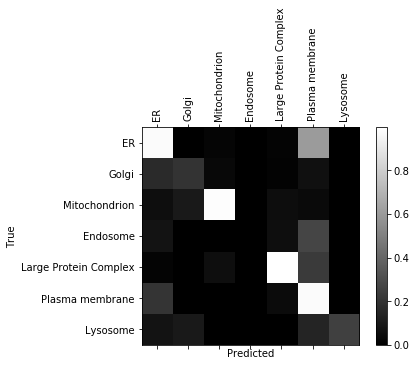

In [127]:
y_pred_test = model.predict(x_test_pad)
y_pred_indices_test = OH_to_label_indices(y_pred_test)
y_pred_label_test = indices_to_cat(y_pred_indices_test)

conf_mx = confusion_matrix(y_test, y_pred_label_test, labels=cat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx / (conf_mx.max(axis=1)+1), cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()